In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [ ]:
figure_folder = "images/feature_analysis/"
dirname = os.getcwd()
dataset_path = os.path.join(dirname, 'data/Rice_MSC_Dataset/Rice_MSC_Dataset.xlsx')

In [ ]:
target_column = "CLASS"

In [ ]:
df = pd.read_excel(dataset_path, sheet_name="Rice_MSC_Dataset")

# Basic analysis

In [ ]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

In [ ]:
df.head(15)

In [ ]:
shape = df.shape
rows_number, columns_number = shape
print(shape)

In [ ]:
df.describe()

## Missing values

In [ ]:
df = df.replace('?',np.nan)
df.info(verbose=True, show_counts=True)

We have a very small amount of missing values so we will drop the rows containing them.

In [ ]:
df = df.dropna()

## Duplicate rows

In [ ]:
duplicate_count = len(df[df.duplicated() == True])
print(f"There are {duplicate_count} duplicated rows.")

The number of duplicated rows is relatively low, so we will drop them.

In [ ]:
df = df.drop_duplicates()

## Visualize features

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Histograms

In [ ]:
for col in numerical_features:
    fg = plt.figure()
    sns.histplot(data=df, x=col, kde=True)
    plt.savefig(f"{figure_folder}histograms/hist-{col}.png")
    plt.close(fg)
    plt.cla()
    plt.clf()

In [ ]:
#Target col info
fg = plt.figure()
sns.histplot(data=df, x=target_column)
plt.savefig(f"{figure_folder}histograms/hist-{target_column}.png")
plt.show()
plt.close(fg)
plt.cla()
plt.clf()

### Correlation heatmap

In [ ]:
fg = plt.figure(figsize=(50,50))
sns.heatmap(data=df.corr())
plt.savefig(f"{figure_folder}corr-heatmap.png", bbox_inches = 'tight', dpi=400)
plt.close(fg)
plt.cla()
plt.clf()

### Violin plots

In [ ]:
for col in numerical_features:
    fg = plt.figure()
    sns.violinplot(data=df, x=target_column, y=col)
    plt.savefig(f"{figure_folder}violins/viol-{col}.png")
    plt.close(fg)
    plt.cla()
    plt.clf()

## Detect outliers

In [ ]:
import OutlierDetection as out_det

In [ ]:
outlierCounts = {}
for col in numerical_features:
    outliersIQR = out_det.indicies_of_outliers(df[col])
    outliersZScore = out_det.outliers_z_score(df[col])
    outliersModZScore = out_det.outliers_modified_z_score(df[col])
    outlierCounts[col] = { "IQR": outliersIQR, "ZScore": outliersZScore, "ModZScore": outliersModZScore }

### Visualize the outliers

In [ ]:
outlier_df = pd.DataFrame.from_dict(outlierCounts, orient = "index")
outlier_count_df = outlier_df.applymap(lambda x: len(x))

In [ ]:
fg = plt.figure(figsize=(4,40))
sns.heatmap(data=outlier_count_df, annot=True, fmt="d", cmap="Greens")
plt.savefig(f"{figure_folder}outlier-heatmap.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fg)
plt.cla()
plt.clf()

# Preprocessing

## Encoding the target variable

In [ ]:
target_column_dict = { "Basmati": 0, "Arborio": 1, "Jasmine": 2, "Ipsala": 3, "Karacadag": 4 }
reverse_target_column_dict = { 0: "Basmati", 1: "Arborio", 2: "Jasmine", 3: "Ipsala", 4: "Karacadag" }
df[target_column] = df[target_column].replace(target_column_dict)

## Scaling

Considering the high number of outliers across features (up to 20%), and the indication that they are important for predicting the target variable, we won't remove them, but try to balance them out through scaling.

### Define scaling functions

In [ ]:
import sklearn.preprocessing as preproc

In [ ]:
#Define scaling functions
def minmax_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    scaler = preproc.MinMaxScaler(feature_range=(0, 1))
    df[columns_toscale] = scaler.fit_transform(df[columns_toscale])
    return df               
         
def standard_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    std_scaler = preproc.StandardScaler()
    df[columns_toscale] = std_scaler.fit_transform(df[columns_toscale])
    return df
    
def robust_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    rbst_scaler = preproc.RobustScaler()
    df[columns_toscale] = rbst_scaler.fit_transform(df[columns_toscale])
    return df

def quantile_scale(dataframe: pd.DataFrame, columns_toscale: list, distribution: str):
    df = dataframe.copy()
    quantile_transformer = preproc.QuantileTransformer(random_state=0, output_distribution=distribution)
    df[columns_toscale] = quantile_transformer.fit_transform(df[columns_toscale])
    return df

def power_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    power_transformer = preproc.PowerTransformer()
    df[columns_toscale] = power_transformer.fit_transform(df[columns_toscale])
    return df

In [ ]:
dfs_touse = {}

In [ ]:
dfs_touse["MinMax"] = minmax_scale(df, numerical_features) 
dfs_touse["Standard"] = standard_scale(df, numerical_features)
dfs_touse["Robust"] = robust_scale(df, numerical_features) 
dfs_touse["Quantile (Uniform)"] = quantile_scale(df, numerical_features, "uniform") 
dfs_touse["Quantile (Normal)"] = quantile_scale(df, numerical_features, "normal") 
dfs_touse["Power"] = power_scale(df, numerical_features)
dfs_touse["Raw"] = df

# Testing

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import time
from keras.utils import np_utils
import signal
import multiprocessing

In [ ]:
num_workers = 6

#Init parallelization assets
def init_worker():
    ''' Add KeyboardInterrupt exception to mutliprocessing workers '''
    signal.signal(signal.SIGINT, signal.SIG_IGN)

def getMultiProcPool():
    return multiprocessing.Pool(num_workers, init_worker)

#### Define reference test

In [ ]:
scoring_metrics = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted')
    }

def reference_test(model, data, label, printRes = False):
    starttime = time.perf_counter()
    cv_results = cross_validate(model, data.drop(columns=[target_column]), data[target_column], scoring=scoring_metrics,
         cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1), n_jobs=-1, return_estimator=True, error_score='raise')
    endtime = time.perf_counter()
    
    AccuScores = cv_results['test_accuracy']
    PrecScores = cv_results['test_precision']
    RecScores = cv_results['test_recall']
    F1Scores = cv_results['test_f1_score']

    AccuScores = np.absolute(AccuScores)
    PrecScores = np.absolute(PrecScores)
    RecScores = np.absolute(RecScores)
    F1Scores = np.absolute(F1Scores)

    print(f"{label} - time to cross validate: {endtime - starttime:0.4f}s", flush=True)
    
    # summarize the model performance
    if (printRes == True):
        print(f'{label} - scoring results:', flush=True)
        print('Accuracy: {:.3%}'.format(np.mean(AccuScores)), flush=True)
        print('Precision: {:.3%}'.format(np.mean(PrecScores)), flush=True)
        print('Recall: {:.3%}'.format(np.mean(RecScores)), flush=True)
        print('F1 Score: {:.3%}'.format(np.mean(F1Scores)), flush=True)
        
    return {
        'Accuracy': np.mean(AccuScores),
        'Precision': np.mean(PrecScores),
        'Recall': np.mean(RecScores),
        'F1': np.mean(F1Scores),
        'Accuracy - std': np.std(AccuScores),
        'Precision - std': np.std(PrecScores),
        'Recall - std': np.std(RecScores),
        'F1 - std': np.std(F1Scores)
    }

#### Define basic network test

In [ ]:
def test_network(network, X_train, X_test, X_val, Y_val, Y_train, Y_test, class_map, label, batch_size, epochs, callbacks=None):
    Y_train_enc = np_utils.to_categorical(Y_train, num_classes=5)
    Y_test_enc = np_utils.to_categorical(Y_test, num_classes=5)
    Y_val_enc = np_utils.to_categorical(Y_val, num_classes=5)
    
    starttime = time.perf_counter()
    history = network.fit(X_train, Y_train_enc,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data = (X_val, Y_val_enc),
          verbose=0)
    traintime = time.perf_counter() - starttime

    starttime = time.perf_counter()
    Y_pred = np.argmax(network.predict(X_test), axis=-1)
    result = classification_report(Y_test, Y_pred, output_dict=True)
    scores = network.evaluate(X_test, Y_test_enc, verbose=0)
    testtime = time.perf_counter() - starttime
    
    print(f"{label}:")
    print(f"\tTime to train: {traintime:0.4f}s")
    print(f"\tTime to test: {testtime:0.4f}s", flush = True)

    return {
        'Accuracy': scores[1],
        f'Precision_{class_map[0]}': result['0']['precision'],
        f'Precision_{class_map[1]}': result['1']['precision'],
        f'Precision_{class_map[2]}': result['2']['precision'],
        f'Precision_{class_map[3]}': result['3']['precision'],
        f'Precision_{class_map[4]}': result['4']['precision'],
        'Precision_avg': result['weighted avg']['precision'],
        'Precision_std': np.std([result['0']['precision'],result['1']['precision'],result['2']['precision'],result['3']['precision'],result['4']['precision']]),
        f'Recall_{class_map[0]}': result['0']['recall'],
        f'Recall_{class_map[1]}': result['1']['recall'],
        f'Recall_{class_map[2]}': result['2']['recall'],
        f'Recall_{class_map[3]}': result['3']['recall'],
        f'Recall_{class_map[4]}': result['4']['recall'],
        'Recall_avg': result['weighted avg']['recall'],
        'Recall_std': np.std([result['0']['recall'],result['1']['recall'],result['2']['recall'],result['3']['recall'],result['4']['recall']]),
        f'F1_{class_map[0]}': result['0']['f1-score'],
        f'F1_{class_map[1]}': result['1']['f1-score'],
        f'F1_{class_map[2]}': result['2']['f1-score'],
        f'F1_{class_map[3]}': result['3']['f1-score'],
        f'F1_{class_map[4]}': result['4']['f1-score'],
        'F1_avg': result['weighted avg']['f1-score'],
        'F1_std': np.std([result['0']['f1-score'],result['1']['f1-score'],result['2']['f1-score'],result['3']['f1-score'],result['4']['f1-score']])
    }, history

#### Define extensive network test

In [80]:
def cv_test_network(build_network, data, class_map, label, batch_size, epochs, callbacks=None, network_build_param=None):
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    accuracy = 0
    precision_0 = 0
    precision_1 = 0
    precision_2 = 0
    precision_3 = 0
    precision_4 = 0
    precision_avg = 0
    precision_std = 0
    recall_0 = 0
    recall_1 = 0
    recall_2 = 0
    recall_3 = 0
    recall_4 = 0
    recall_avg = 0
    recall_std = 0
    f1_0 = 0
    f1_1 = 0
    f1_2 = 0
    f1_3 = 0
    f1_4 = 0
    f1_avg = 0
    f1_std = 0
    
    fold_no = 0
    for train_indices, test_indices in cv.split(X, Y):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]
        
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train)

        Y_train_enc = np_utils.to_categorical(Y_train, num_classes=5)
        Y_test_enc = np_utils.to_categorical(Y_test, num_classes=5)
        Y_val_enc = np_utils.to_categorical(Y_val, num_classes=5)

        network = None       
        if network_build_param is None:
            network = build_network()
        else:
            network = build_network(network_build_param)
        
        starttime = time.perf_counter()
        network.fit(X_train, Y_train_enc,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              validation_data = (X_val, Y_val_enc),
              verbose=0)
        endttime = time.perf_counter()
        
        print(f"{label} - fold number {fold_no}:")
        print(f"\tTime to train: {endttime - starttime:0.4f}s")
        
        starttime = time.perf_counter()
        Y_pred = np.argmax(network.predict(X_test), axis=-1)
        result = classification_report(Y_test, Y_pred, output_dict=True)
        scores = network.evaluate(X_test, Y_test_enc, verbose=0)
        endttime = time.perf_counter()

        print(f"\tTime to test: {endttime - starttime:0.4f}s")
        
        accuracy += scores[1]
        precision_0 += result['0']['precision']
        precision_1 += result['1']['precision']
        precision_2 += result['2']['precision']
        precision_3 += result['3']['precision']
        precision_4 += result['4']['precision']
        precision_avg += result['weighted avg']['precision']
        precision_std += np.std([result['0']['precision'],result['1']['precision'],result['2']['precision'],result['3']['precision'],result['4']['precision']])
        recall_0 += result['0']['recall']
        recall_1 += result['1']['recall']
        recall_2 += result['2']['recall']
        recall_3 += result['3']['recall']
        recall_4 += result['4']['recall']
        recall_avg += result['weighted avg']['recall']
        recall_std += np.std([result['0']['recall'],result['1']['recall'],result['2']['recall'],result['3']['recall'],result['4']['recall']])
        f1_0 += result['0']['f1-score']
        f1_1 += result['1']['f1-score']
        f1_2 += result['2']['f1-score']
        f1_3 += result['3']['f1-score']
        f1_4 += result['4']['f1-score']
        f1_avg += result['weighted avg']['f1-score']
        f1_std += np.std([result['0']['f1-score'],result['1']['f1-score'],result['2']['f1-score'],result['3']['f1-score'],result['4']['f1-score']])
        
        fold_no += 1
        
    accuracy /= fold_no
    precision_0 /= fold_no
    precision_1 /= fold_no
    precision_2 /= fold_no
    precision_3 /= fold_no
    precision_4 /= fold_no
    precision_avg /= fold_no
    precision_std /= fold_no
    recall_0 /= fold_no
    recall_1 /= fold_no
    recall_2 /= fold_no
    recall_3 /= fold_no
    recall_4 /= fold_no
    recall_avg /= fold_no
    recall_std /= fold_no
    f1_0 /= fold_no
    f1_1 /= fold_no
    f1_2 /= fold_no
    f1_3 /= fold_no
    f1_4 /= fold_no
    f1_avg /= fold_no
    f1_std /= fold_no
    
    return {
        'Accuracy': accuracy,
        f'Precision_{class_map[0]}': precision_0,
        f'Precision_{class_map[1]}': precision_1,
        f'Precision_{class_map[2]}': precision_2,
        f'Precision_{class_map[3]}': precision_3,
        f'Precision_{class_map[4]}': precision_4,
        'Precision_avg': precision_avg,
        'Precision_std': precision_std,
        f'Recall_{class_map[0]}': recall_0,
        f'Recall_{class_map[1]}': recall_1,
        f'Recall_{class_map[2]}': recall_2,
        f'Recall_{class_map[3]}': recall_3,
        f'Recall_{class_map[4]}': recall_4,
        'Recall_avg': recall_avg,
        'Recall_std': recall_std,
        f'F1_{class_map[0]}': f1_0,
        f'F1_{class_map[1]}': f1_1,
        f'F1_{class_map[2]}': f1_2,
        f'F1_{class_map[3]}': f1_3,
        f'F1_{class_map[4]}': f1_4,
        'F1_avg': f1_avg,
        'F1_std': f1_std
    }


## Different scaling methods

We will define a simple neural network to test different scaling methods, before proceeding with more detailed testing.

### Define basic neural network

In [ ]:
def build_basic_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation='relu'))
    network.add(Dense(80, activation='relu'))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

### Perform reference tests

In [ ]:
from sklearn.tree import DecisionTreeClassifier

reference_results = {}
decision_tree = DecisionTreeClassifier()

In [ ]:
#Helper method
def perform_ref_test(model, label, repetition=1):
    global reference_results

    #Perform first repetition
    reference_results[label] = reference_test(model, dfs_touse[label], label + "1")

    #Perform the rest of the repetions and calculate a rolling mean
    for i in range(2, repetition + 1):
        local_results = reference_test(model, dfs_touse[label], label + str(i))

        for key, value in local_results.items():
            reference_results[label][key] = np.mean([value, reference_results[label][key]])

In [ ]:
print('Performing reference tests with a DecisionTree classifier...')

perform_ref_test(decision_tree, 'MinMax', 10)
perform_ref_test(decision_tree, 'Standard', 10)
perform_ref_test(decision_tree, 'Robust', 10)
perform_ref_test(decision_tree, 'Quantile (Uniform)', 10)
perform_ref_test(decision_tree, 'Quantile (Normal)', 10)
perform_ref_test(decision_tree, 'Power', 10)
perform_ref_test(decision_tree, 'Raw', 10)

In [ ]:
#Compile results
reference_df = pd.DataFrame.from_dict(reference_results, orient='index')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Decision Tree Reference Results')

acc_reference_df = reference_df[['Accuracy', 'Precision', 'Recall', 'F1']]
sns.heatmap(acc_reference_df, annot=acc_reference_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Scaling methods")

std_reference_df = reference_df[['Accuracy - std', 'Precision - std', 'Recall - std', 'F1 - std']]
sns.heatmap(std_reference_df, annot=std_reference_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}reference-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

### Perform network tests

In [ ]:
from sklearn.model_selection import train_test_split

network_results = {}

In [ ]:
def perform_net_test(build_network, label, batch_size, epochs, callbacks = None):
    data = dfs_touse[label]
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    #Perform first repetition
    res, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label, batch_size, epochs, callbacks = callbacks)
    global network_results
    network_results[label] = res  

    return history

def perform_rep_net_test(build_network, label, batch_size, epochs, repetitions = 1, callbacks = None):
    data = dfs_touse[label]
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    #Perform first repetition
    res, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label + "1", batch_size, epochs, callbacks = callbacks)
    global network_results
    network_results[label] = res  

    histories = {}
    histories[1] = history

    #Perform the rest of the repetions and calculate a rolling mean
    for i in range(2, repetitions + 1):
        local_results, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label + str(i), batch_size, epochs, callbacks = callbacks)
        histories[i] = history

        for key, value in local_results.items():
            network_results[label][key] = np.mean([value, network_results[label][key]])

    return histories, label

In [41]:
print("Performing basic network testing over different scaling methods...")
perform_rep_net_test(build_basic_network, 'MinMax', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Standard', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Robust', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Quantile (Uniform)', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Quantile (Normal)', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Power', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Raw', 100, 3, 10)

701/701 [==============================] - 0s 330us/step
Raw5:
	Time to train: 32.9598s
	Time to test: 26.9584s
701/701 [==============================] - 0s 430us/step
Raw6:
	Time to train: 31.8572s
	Time to test: 29.1421s
701/701 [==============================] - 0s 309us/step
Raw7:
	Time to train: 33.2847s
	Time to test: 27.9838s
701/701 [==============================] - 0s 312us/step
Raw8:
	Time to train: 32.7382s
	Time to test: 28.0957s
701/701 [==============================] - 0s 353us/step
Raw9:
	Time to train: 33.0908s
	Time to test: 28.0507s
701/701 [==============================] - 0s 347us/step
Raw10:
	Time to train: 33.1636s
	Time to test: 28.1713s


({1: <keras.callbacks.History at 0x1d28211b130>,
  2: <keras.callbacks.History at 0x1d29256fac0>,
  3: <keras.callbacks.History at 0x1d2900a7100>,
  4: <keras.callbacks.History at 0x1d28f9d30a0>,
  5: <keras.callbacks.History at 0x1d296be66e0>,
  6: <keras.callbacks.History at 0x1d28ee8b040>,
  7: <keras.callbacks.History at 0x1d2967694b0>,
  8: <keras.callbacks.History at 0x1d28c207100>,
  9: <keras.callbacks.History at 0x1d28cb3bfa0>,
  10: <keras.callbacks.History at 0x1d290a9fb20>},
 'Raw')

In [42]:
#Compile results
scaling_df = pd.DataFrame.from_dict(network_results, orient='index')

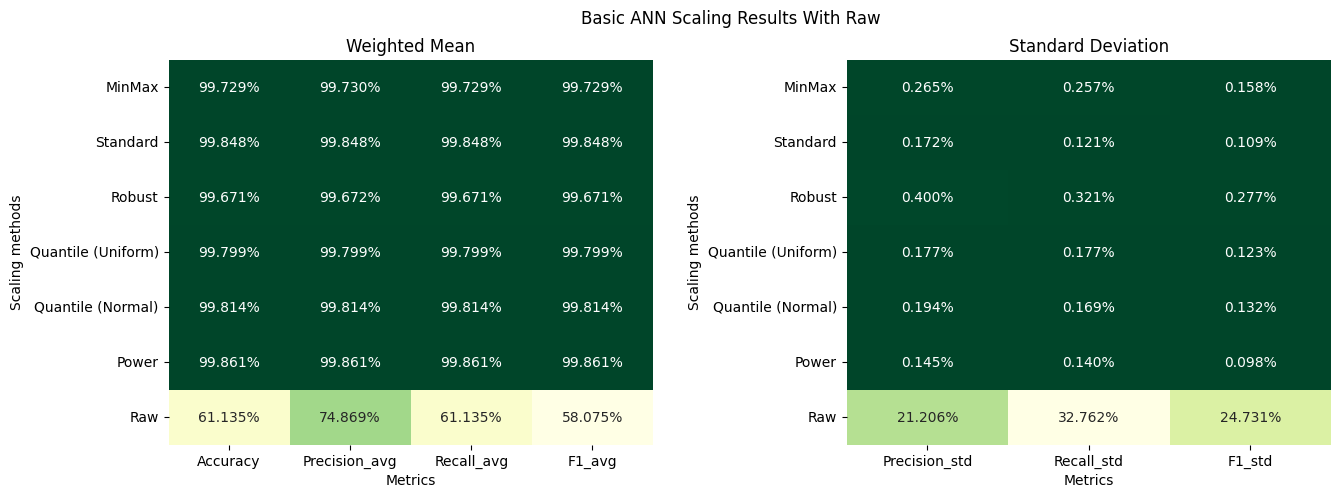

<Figure size 640x480 with 0 Axes>

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Basic ANN Scaling Results With Raw')

acc_scaling_df = scaling_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_scaling_df, annot=acc_scaling_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Weighted Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Scaling methods")

std_scaling_df = scaling_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_scaling_df, annot=std_scaling_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}scaling-network-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

As we can see, the non processed data set gives us pretty poor performance, so we will remove it from the results to get better information.

In [44]:
scaling_df = scaling_df.drop('Raw')

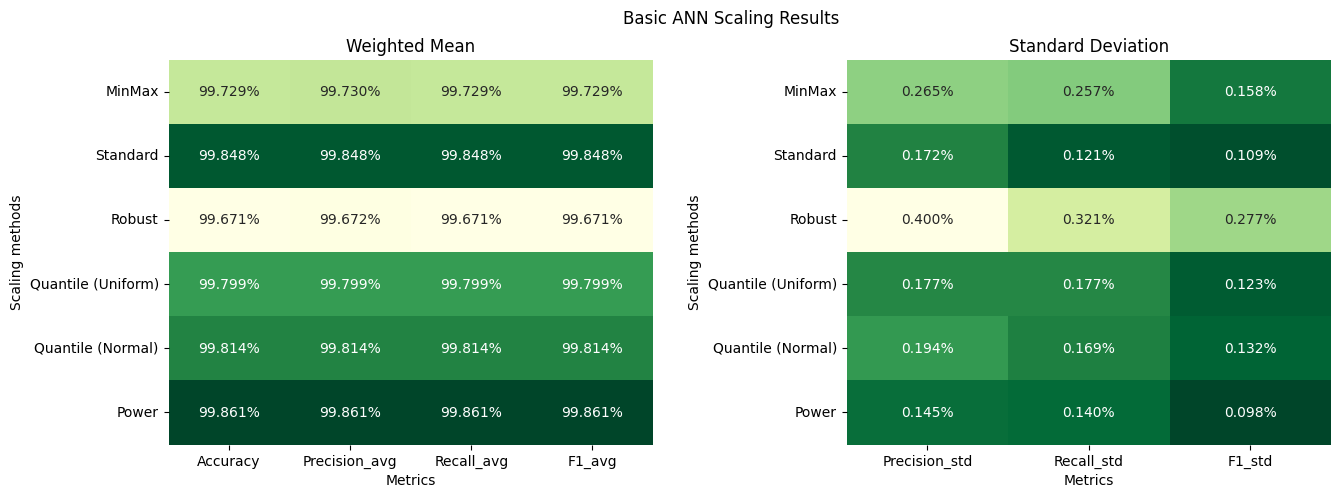

<Figure size 640x480 with 0 Axes>

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Basic ANN Scaling Results')

acc_scaling_df = scaling_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_scaling_df, annot=acc_scaling_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Weighted Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Scaling methods")

std_scaling_df = scaling_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_scaling_df, annot=std_scaling_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}scaling-network-results-without-raw.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

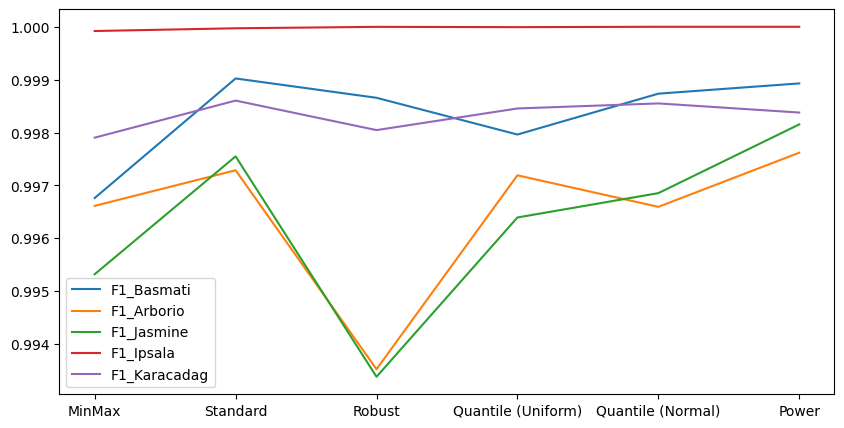

<Figure size 640x480 with 0 Axes>

In [46]:
#Check out F1 scores per classes
f1_scaling_df = scaling_df[['F1_Basmati','F1_Arborio','F1_Jasmine','F1_Ipsala','F1_Karacadag']]

fg = f1_scaling_df.plot(figsize=(10,5))
plt.savefig(f"{figure_folder}scaling-network-results-classes.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close()
plt.cla()
plt.clf()

### Compare results

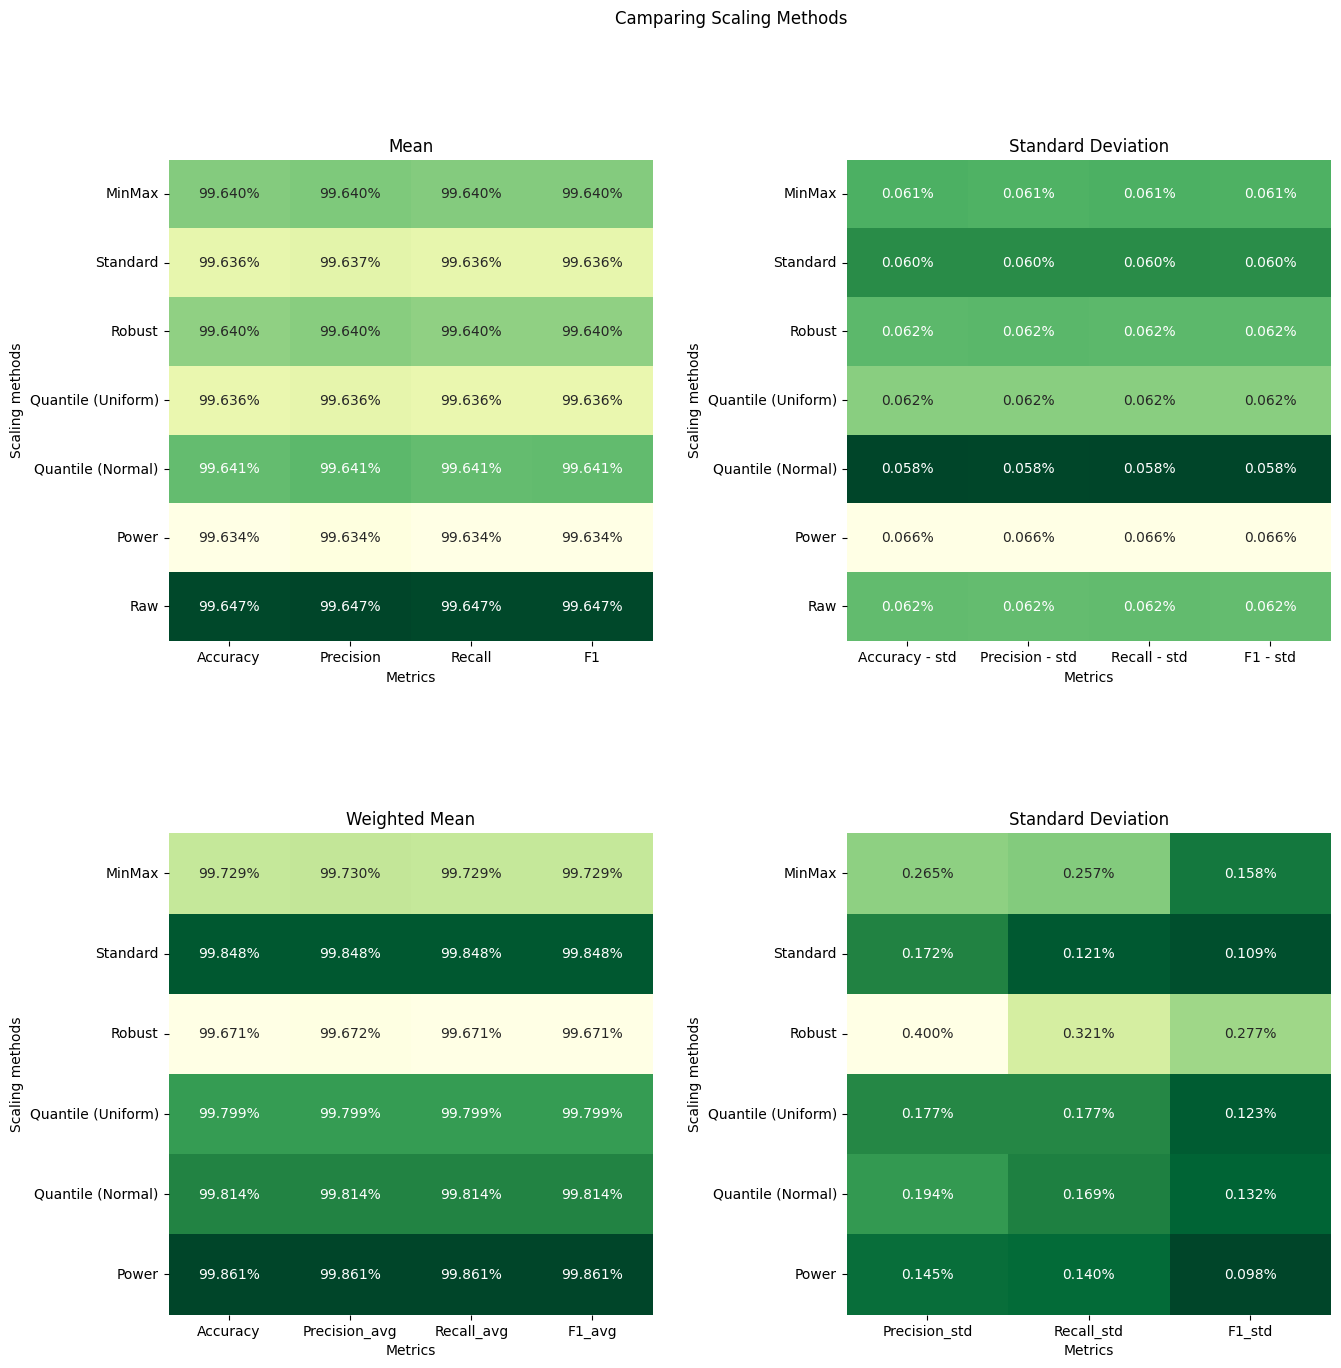

<Figure size 640x480 with 0 Axes>

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Camparing Scaling Methods')

acc_reference_df = reference_df[['Accuracy', 'Precision', 'Recall', 'F1']]
sns.heatmap(acc_reference_df, annot=acc_reference_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0][0])
axes[0][0].set_title("Mean")
axes[0][0].set_xlabel("Metrics")
axes[0][0].set_ylabel("Scaling methods")

std_reference_df = reference_df[['Accuracy - std', 'Precision - std', 'Recall - std', 'F1 - std']]
sns.heatmap(std_reference_df, annot=std_reference_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[0][1])
axes[0][1].set_title("Standard Deviation")
axes[0][1].set_xlabel("Metrics")
axes[0][1].set_ylabel("Scaling methods")

acc_scaling_df = scaling_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_scaling_df, annot=acc_scaling_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[1][0])
axes[1][0].set_title("Weighted Mean")
axes[1][0].set_xlabel("Metrics")
axes[1][0].set_ylabel("Scaling methods")

std_scaling_df = scaling_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_scaling_df, annot=std_scaling_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1][1])
axes[1][1].set_title("Standard Deviation")
axes[1][1].set_xlabel("Metrics")
axes[1][1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}scaling-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

Even though the results are relatively similar betwen the power transformed and the standardized dataset, the dataset that was standardized has better peformance with the basic ANN, so that's the one we will use for further analysis.

# Optimizing the network

In [48]:
optimized_network_results = {}

## Reducing overfitting

In [49]:
def plot_results (history, label):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(label)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{figure_folder}{label}.png", bbox_inches = 'tight', dpi=400)
    plt.show()
    plt.close(fig)
    plt.cla()
    plt.clf()

def perform_opt_net_test(build_network, label, batch_size, epochs, callbacks = None):
    data = dfs_touse[label]
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    #Perform first repetition
    res, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label, batch_size, epochs, callbacks = callbacks)
    global optimized_network_results
    optimized_network_results[label] = res  

    return history

In [50]:
history = perform_opt_net_test(build_basic_network, 'Standard', 1000, 20)

701/701 [==============================] - 0s 335us/step
Standard:
	Time to train: 22.4500s
	Time to test: 18.1864s


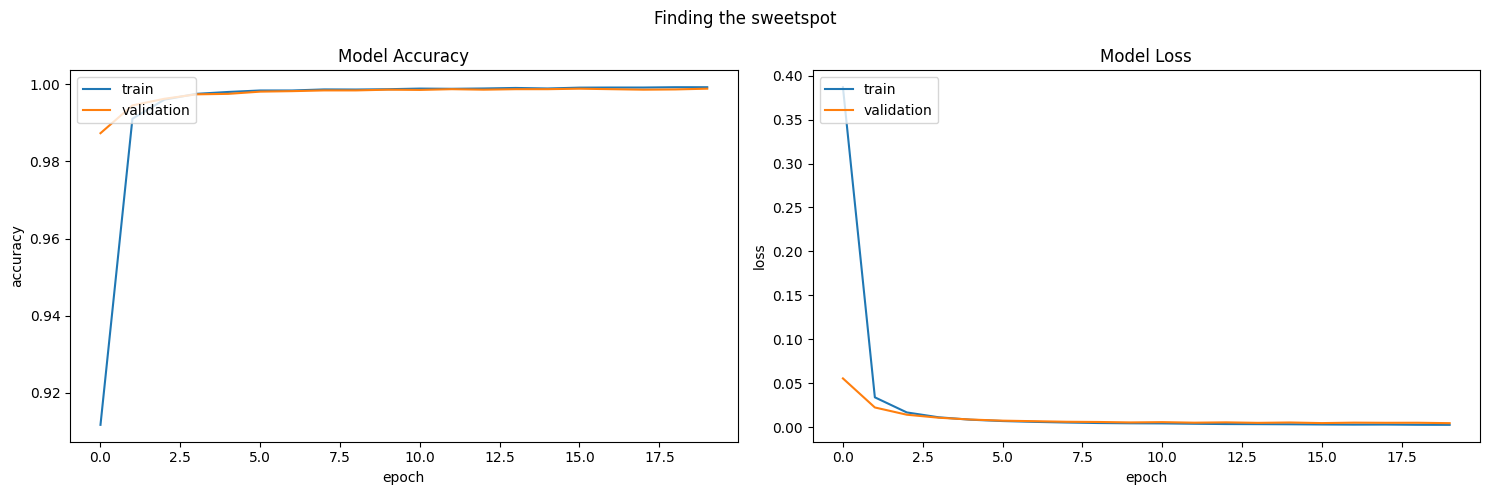

<Figure size 640x480 with 0 Axes>

In [51]:
plot_results(history, "Finding the sweetspot")

Considering our specific situation, where the model's peformance is consistently very good, it's difficult to find the actual point where overfitting starts, but nonetheless, we will attempt multiple traditional methods for combating overfitting, and we will compare the results.

### Weight regularization

In [52]:
#Save previous results
optimized_network_results['Unmodified'] = network_results['Standard']

In [53]:
def build_weighted_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

In [54]:
history = perform_opt_net_test(build_weighted_network, 'Standard', 1000, 20)

optimized_network_results['Weighted'] = optimized_network_results['Standard']
optimized_network_results['Standard'] = None

701/701 [==============================] - 0s 325us/step
Standard:
	Time to train: 22.0661s
	Time to test: 18.0137s


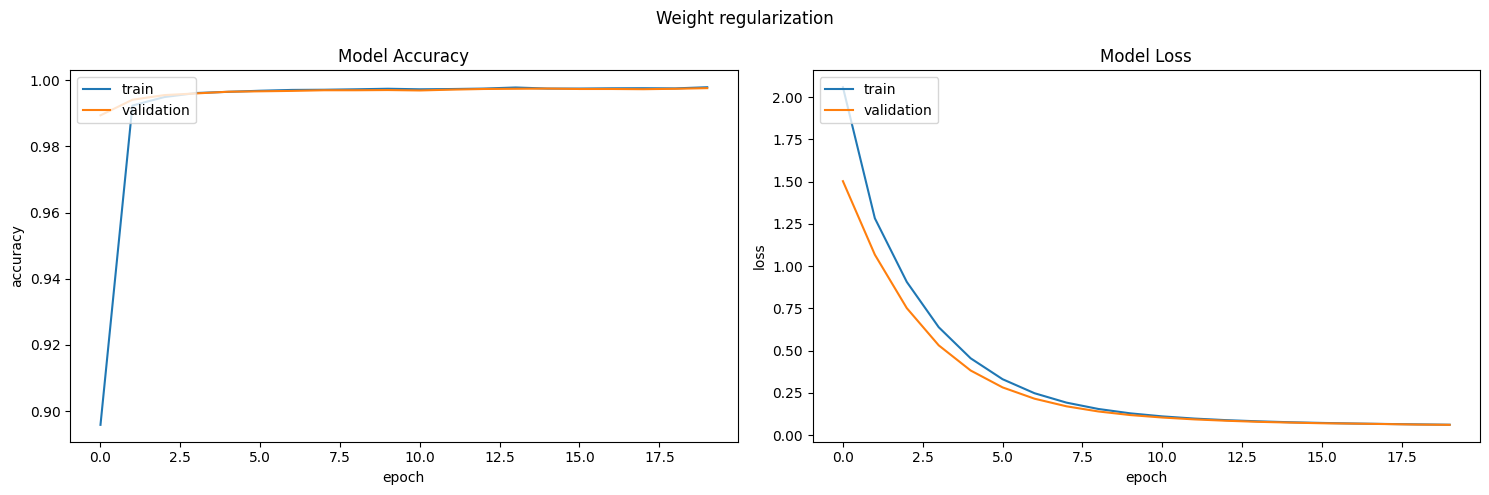

<Figure size 640x480 with 0 Axes>

In [55]:
plot_results(history, "Weight regularization")

### Early stopping

In [56]:
#Prepare callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model 

callbacks = [EarlyStopping(monitor="val_loss", patience=2),
             CSVLogger('history.csv'),
             ModelCheckpoint(filepath="best_model.h5",
             monitor="val_loss",
             save_best_only=True)]

In [57]:
history = perform_opt_net_test(build_basic_network, 'Standard', 1000, 20, callbacks=callbacks)

optimized_network_results['EarlyStopping'] = optimized_network_results['Standard']
optimized_network_results['Standard'] = None

701/701 [==============================] - 0s 350us/step
Standard:
	Time to train: 32.6180s
	Time to test: 35.5581s


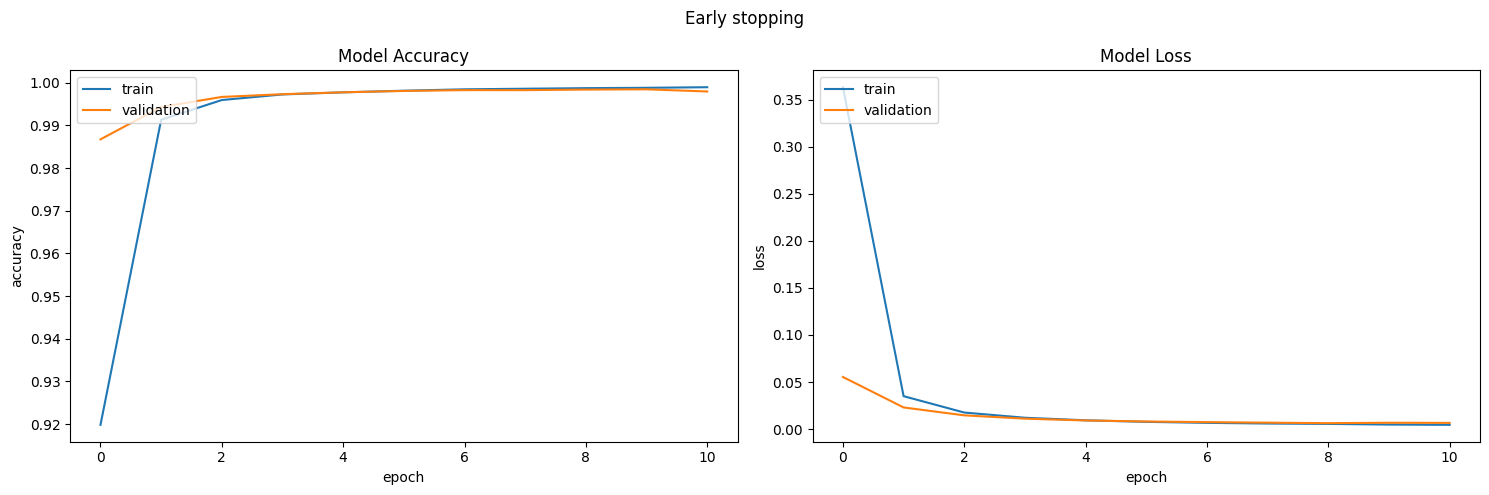

<Figure size 640x480 with 0 Axes>

In [58]:
plot_results(history, "Early stopping")

### Using dropout

In [59]:
def build_dropout_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout

    #Build neural network
    network = Sequential()
    network.add(Dropout(0.2, input_dim=106))
    network.add(Dense(80, activation='relu'))
    network.add(Dropout(0.5))
    network.add(Dense(80, activation='relu'))
    network.add(Dropout(0.5))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

In [60]:
history = perform_opt_net_test(build_dropout_network, 'Standard', 1000, 20)

optimized_network_results['Dropout'] = optimized_network_results['Standard']
optimized_network_results['Standard'] = None

701/701 [==============================] - 0s 356us/step
Standard:
	Time to train: 44.5148s
	Time to test: 35.6868s


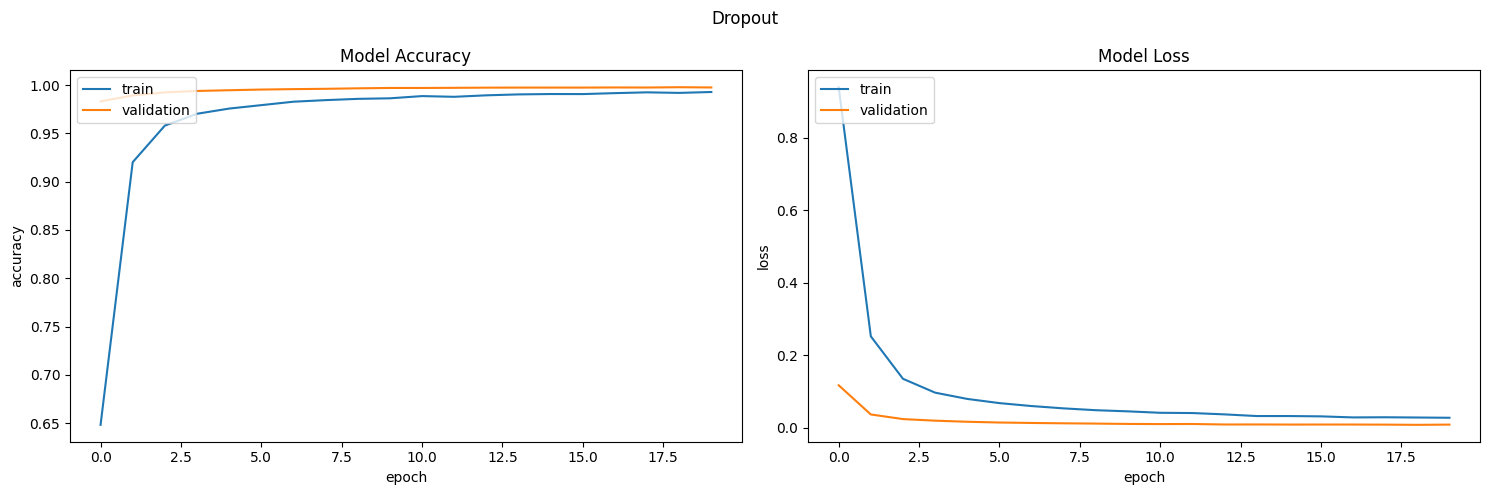

<Figure size 640x480 with 0 Axes>

In [61]:
plot_results(history, "Dropout")

In [62]:
#Compile results
optimized_network_results.pop("Standard")

In [63]:
overfitting_df = pd.DataFrame.from_dict(optimized_network_results, orient='index')

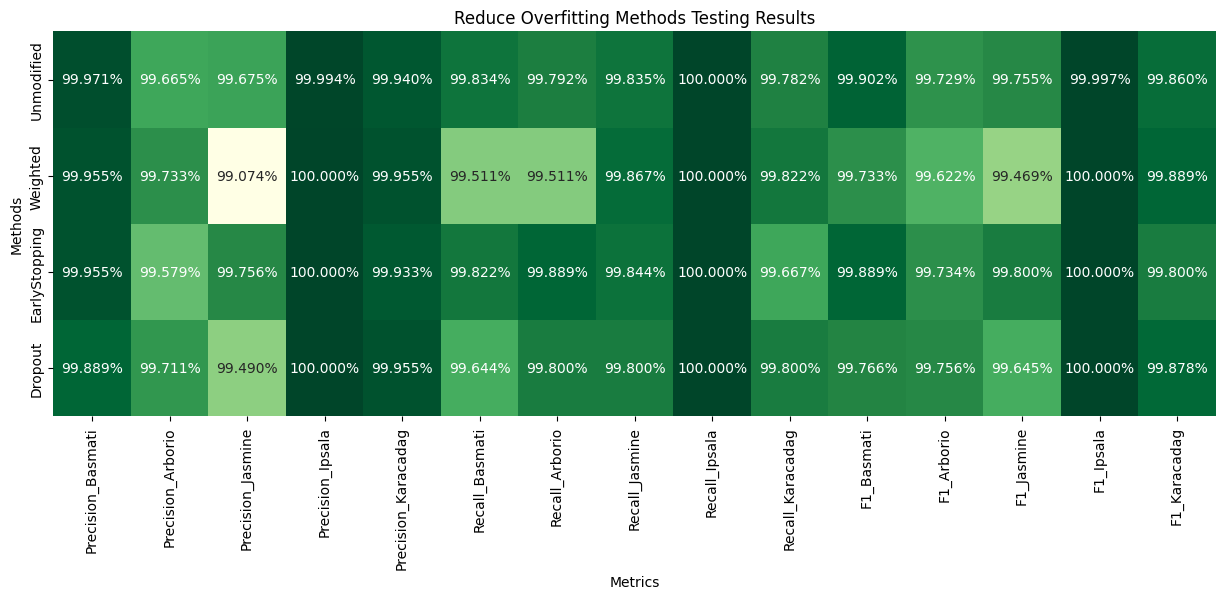

<Figure size 640x480 with 0 Axes>

In [64]:
fig = plt.figure(figsize=(15,5))

class_overfitting_df = overfitting_df.drop(columns=['Accuracy', 'Precision_avg', 'Precision_std', 'Recall_avg', 'Recall_std', 'F1_avg', 'F1_std'])
sns.heatmap(class_overfitting_df, annot=class_overfitting_df, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Reduce Overfitting Methods Testing Results")
plt.xlabel("Metrics")
plt.ylabel("Methods")
plt.savefig(f"{figure_folder}reduce-overfitting.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

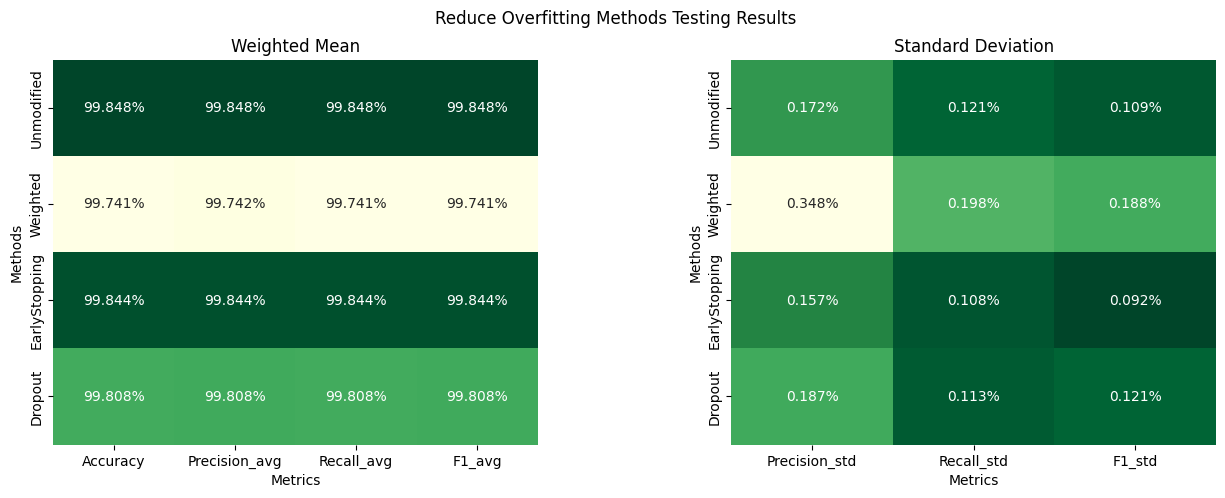

<Figure size 640x480 with 0 Axes>

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Reduce Overfitting Methods Testing Results')

acc_overfitting_df = overfitting_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_overfitting_df, annot=acc_overfitting_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Weighted Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Methods")

std_overfitting_df = overfitting_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_overfitting_df, annot=std_overfitting_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Methods")

plt.savefig(f"{figure_folder}reduce-overfitting-avg.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

Seemingly, the early stopping technique gives us the best results so we will stick with it.

## Trying out different activation functions

In [66]:
param_results = {}
param_history_results = {}

In [82]:
from tensorflow.keras.layers import PReLU

activation_functions = [
    ('ReLU', 'relu'),
    ('Leaky ReLU', 'leaky_relu'),
    ('Parametric ReLU', PReLU()),
    ('ELU', 'elu'),
    ('GeLU', 'gelu'),
    ('Tanh', 'tanh'),
    ('Sigmoid', 'sigmoid'),
    ('Softmax', 'softmax'),
    ('Softplus', 'softplus'),
    ('Softsign', 'softsign')]

def build_activation_network(activation_function, output_activation='softmax'):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation=activation_function))
    network.add(Dense(80, activation=activation_function))
    network.add(Dense(5, activation=output_activation))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    
    return network

def build_sigmoid_activation_network(activation_function):
    return build_activation_network(activation_function, 'sigmoid')
    
def perform_param_test(network, data, label, batch_size, epochs, callbacks = None):
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    res, history = test_network(network, X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label, batch_size, epochs, callbacks = callbacks)
    global param_results
    param_results[label] = res
    
    global param_history_results
    param_history_results[label] = history
    
    return history

def perform_param_cv_test(build_network, data, label, batch_size, epochs, network_param, callbacks = None):
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    res = cv_test_network(build_network, data, reverse_target_column_dict, label, batch_size, 
                            epochs, callbacks = callbacks, network_build_param=network_param)
    
    global param_results
    param_results[label] = res    
    
    return res

701/701 [==============================] - 0s 503us/step
ReLU:
	Time to train: 41.2261s
	Time to test: 36.2194s


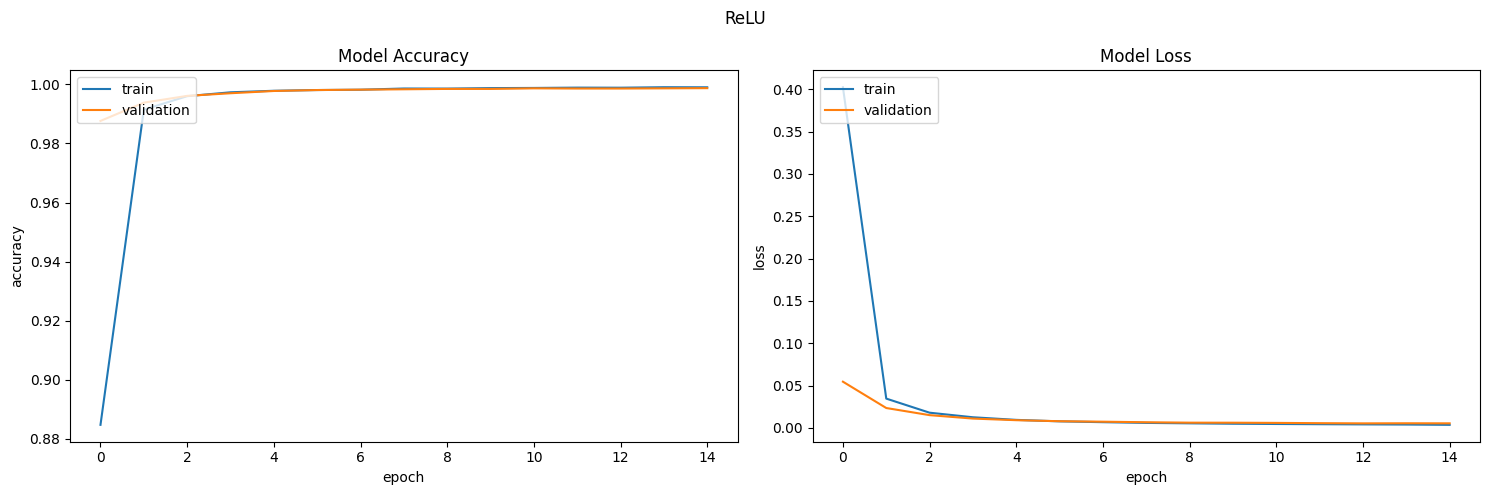

701/701 [==============================] - 0s 443us/step
Leaky ReLU:
	Time to train: 42.2526s
	Time to test: 28.5667s


<Figure size 640x480 with 0 Axes>

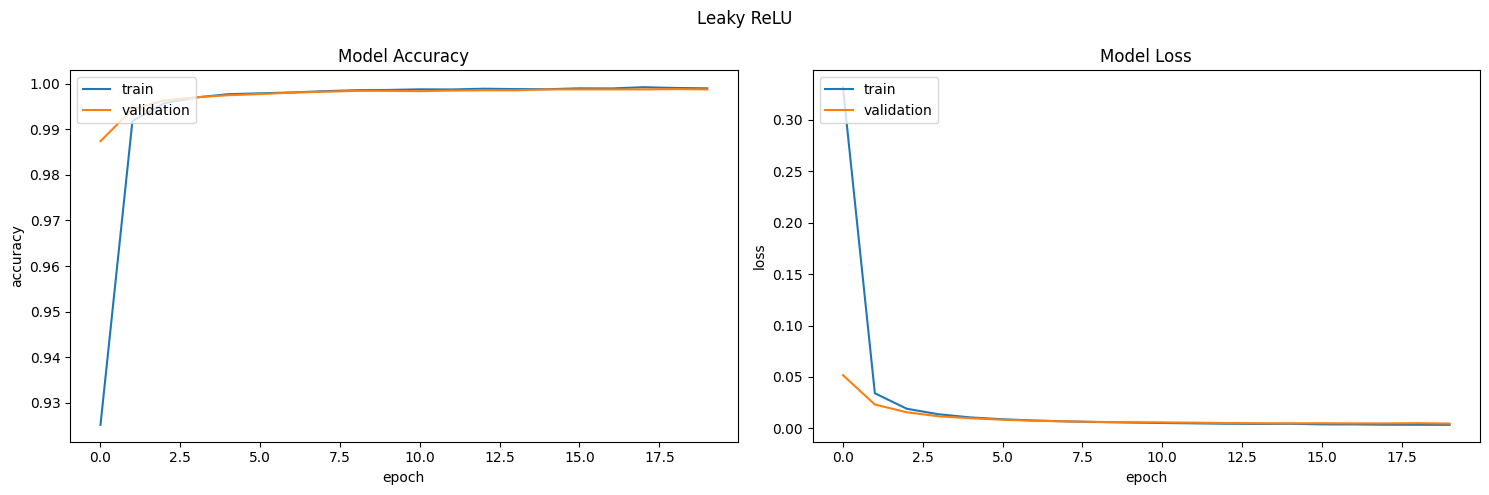

701/701 [==============================] - 0s 400us/step
Parametric ReLU:
	Time to train: 41.7091s
	Time to test: 31.2640s


<Figure size 640x480 with 0 Axes>

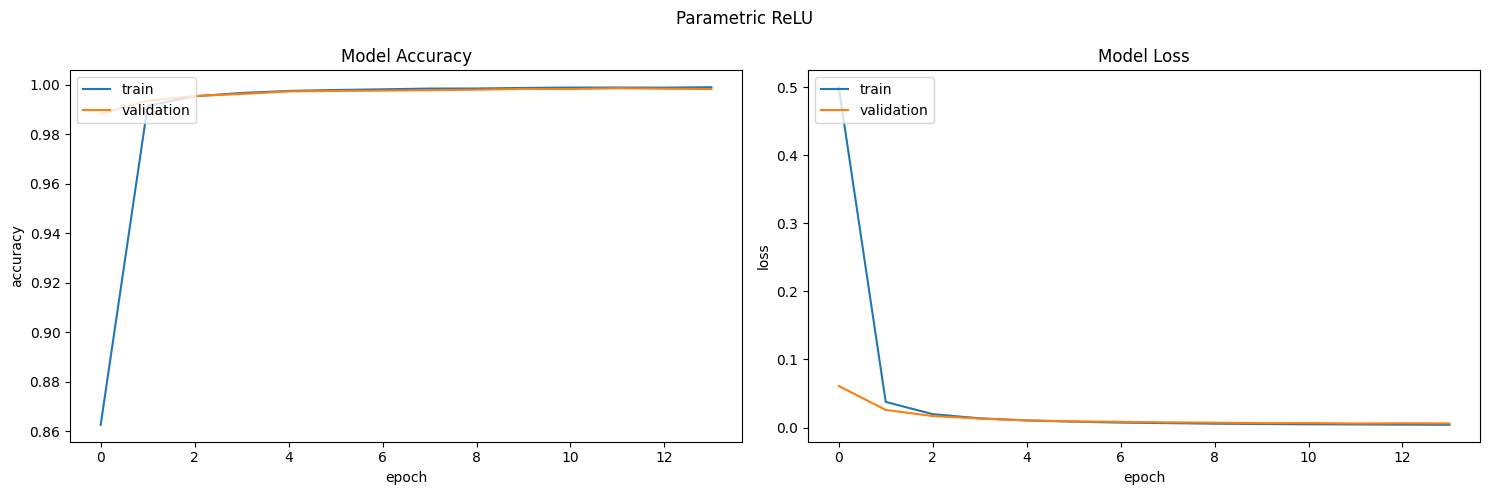

701/701 [==============================] - 0s 392us/step
ELU:
	Time to train: 41.9075s
	Time to test: 32.7379s


<Figure size 640x480 with 0 Axes>

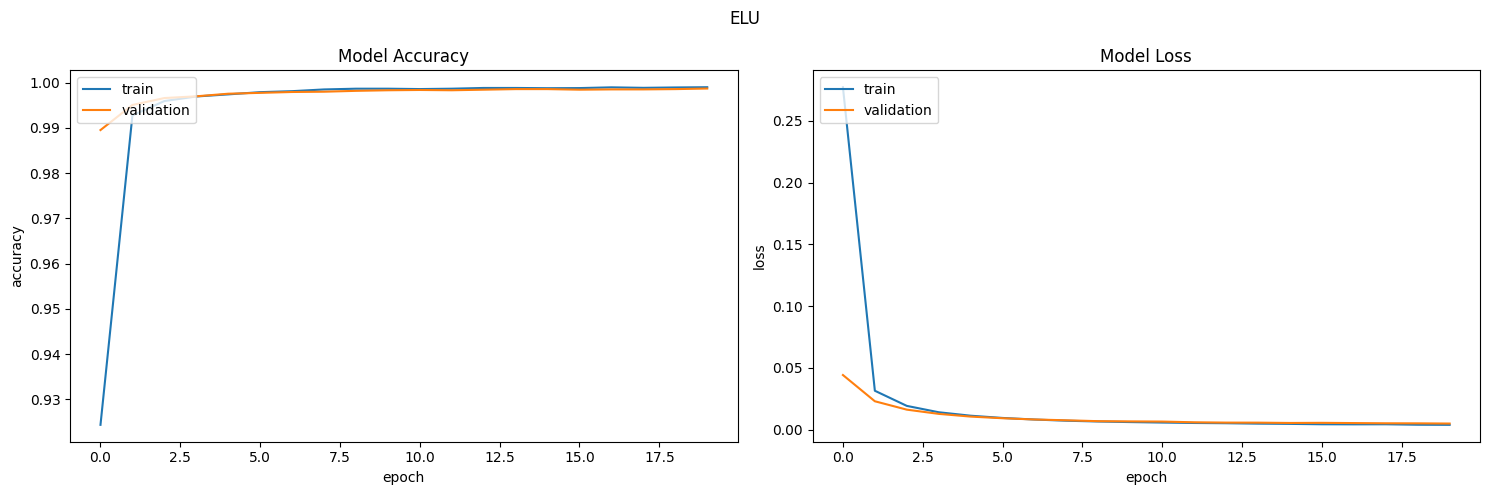

701/701 [==============================] - 0s 312us/step
GeLU:
	Time to train: 40.9729s
	Time to test: 28.8103s


<Figure size 640x480 with 0 Axes>

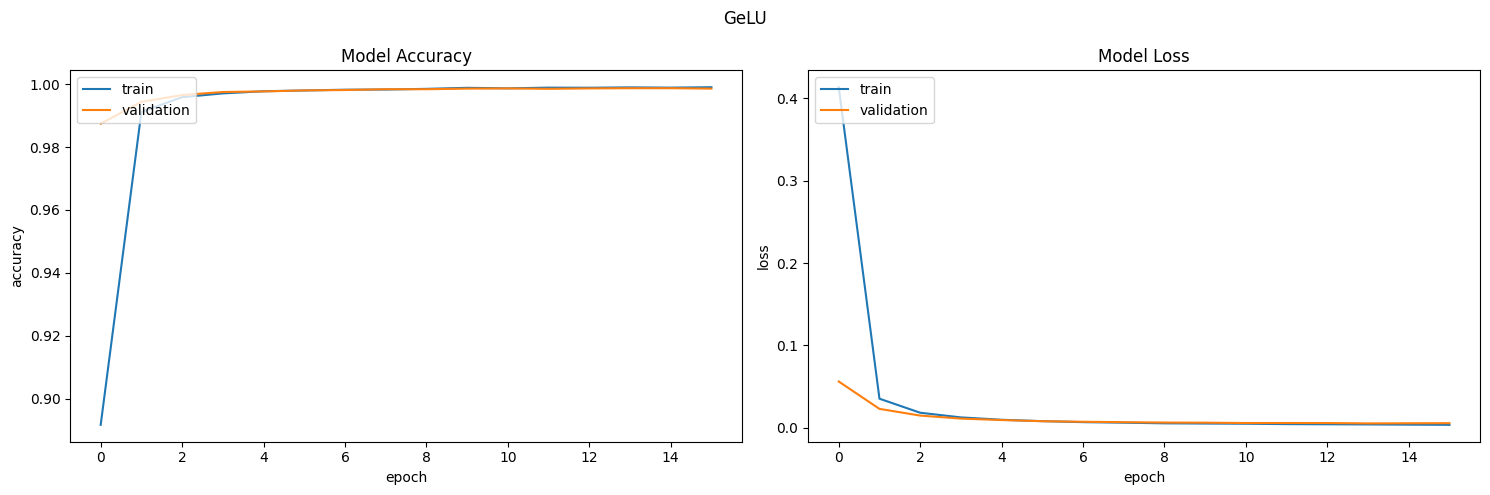

701/701 [==============================] - 0s 410us/step
Tanh:
	Time to train: 41.4481s
	Time to test: 33.0596s


<Figure size 640x480 with 0 Axes>

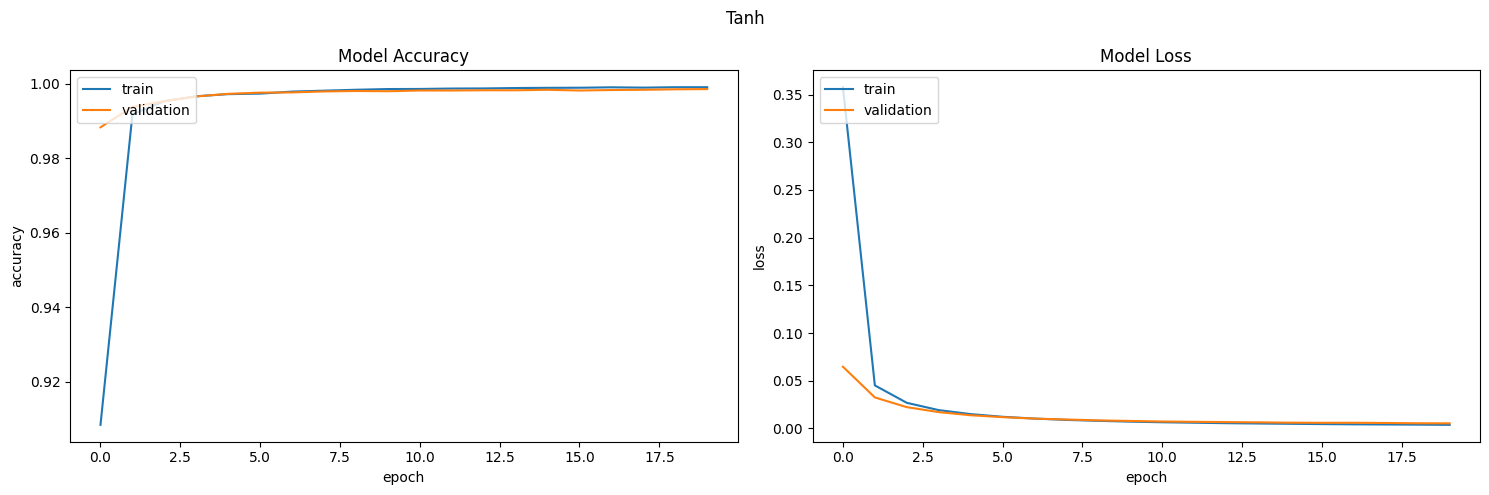

701/701 [==============================] - 0s 320us/step
Sigmoid:
	Time to train: 41.5456s
	Time to test: 32.6497s


<Figure size 640x480 with 0 Axes>

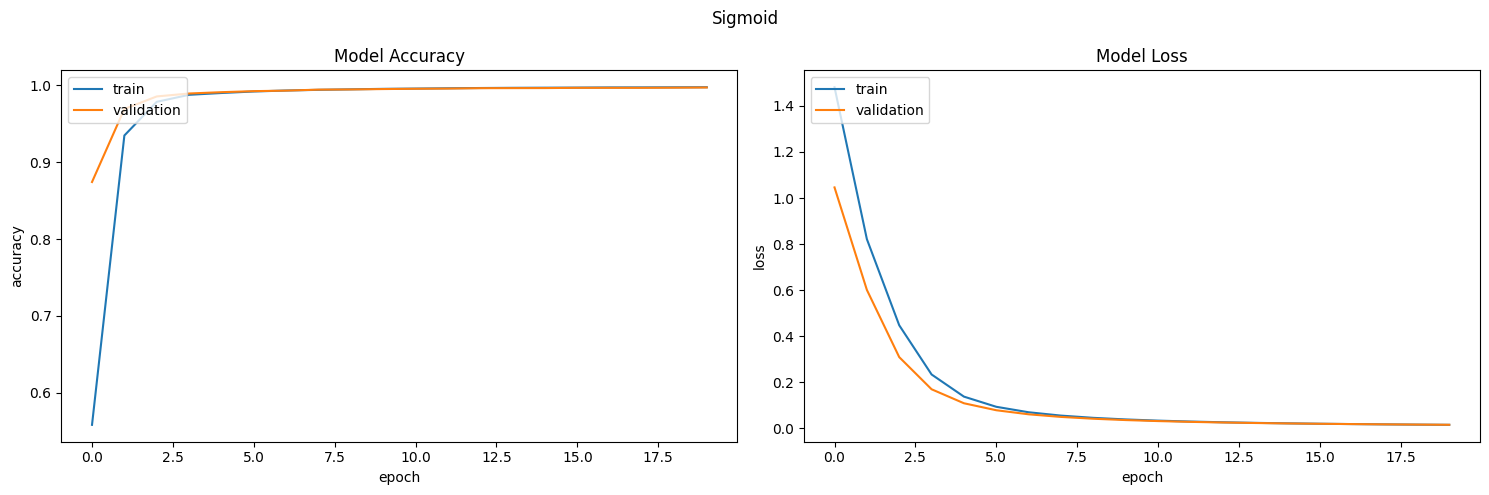

701/701 [==============================] - 0s 305us/step
Softmax:
	Time to train: 40.8478s
	Time to test: 31.5823s


<Figure size 640x480 with 0 Axes>

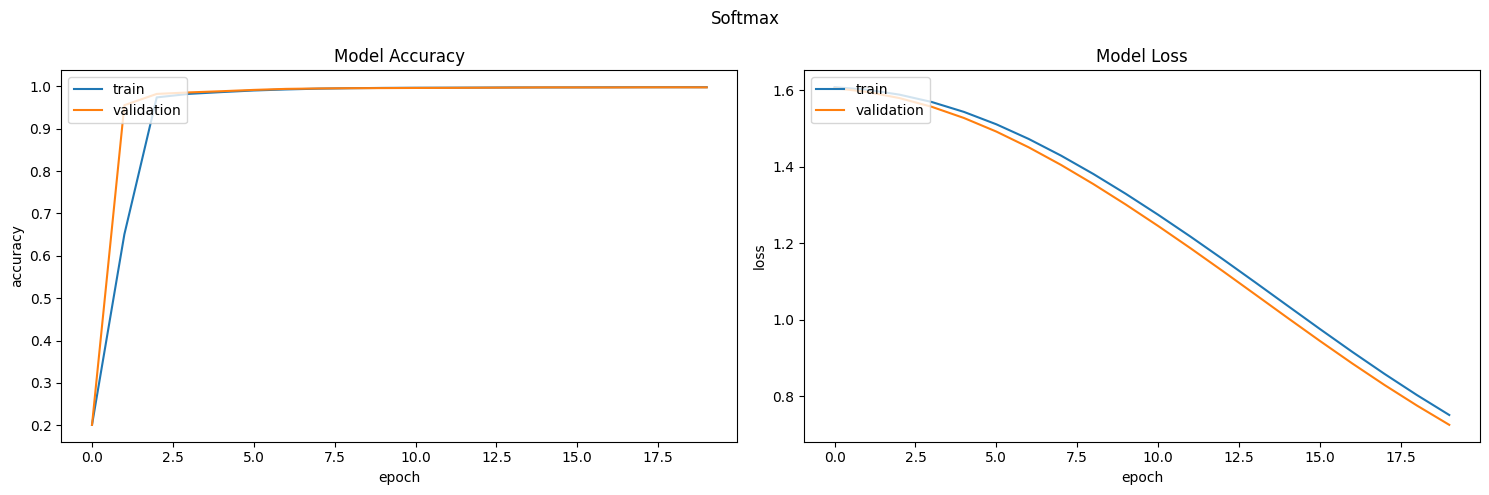

701/701 [==============================] - 0s 340us/step
Softplus:
	Time to train: 41.7163s
	Time to test: 33.1336s


<Figure size 640x480 with 0 Axes>

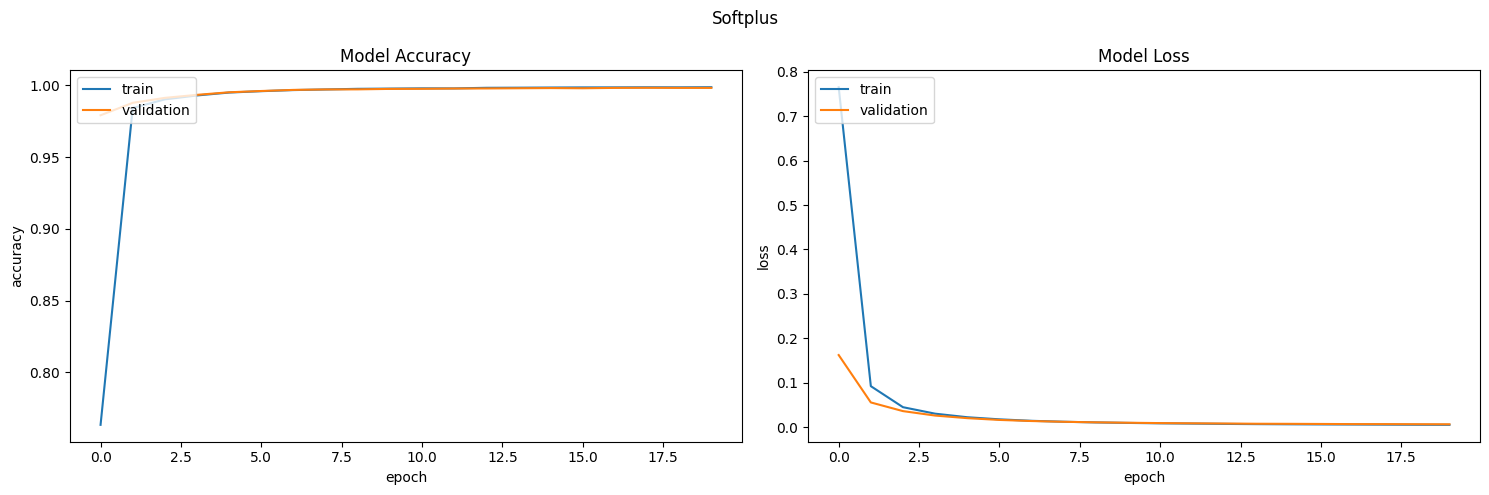

701/701 [==============================] - 0s 350us/step
Softsign:
	Time to train: 43.4034s
	Time to test: 31.5583s


<Figure size 640x480 with 0 Axes>

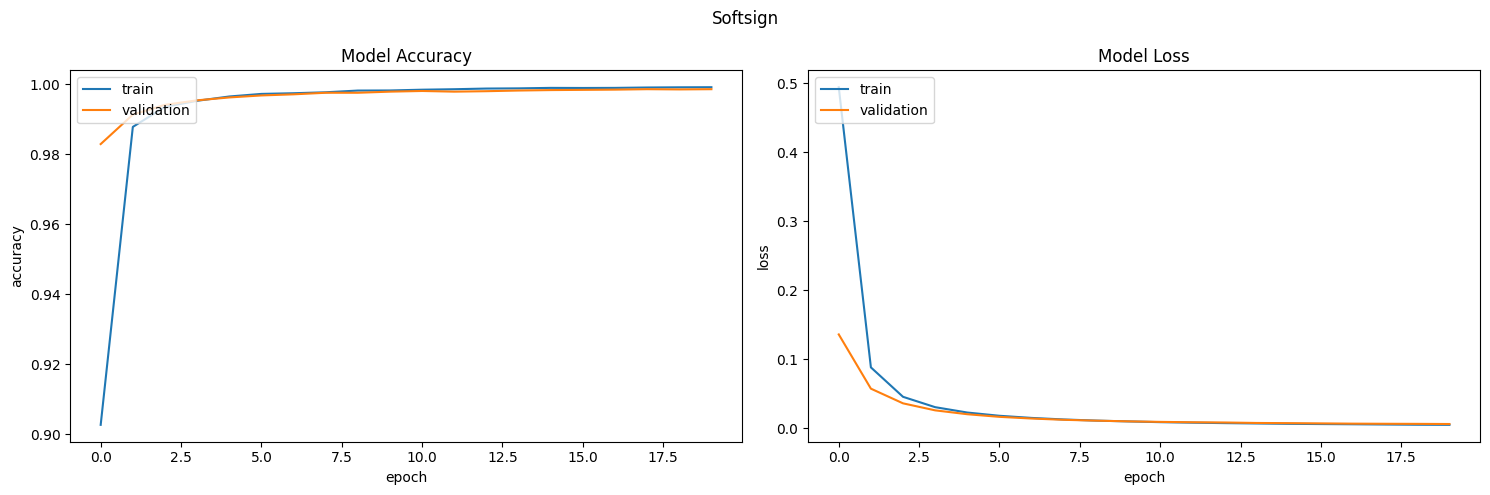

<Figure size 640x480 with 0 Axes>

In [68]:
#Test out all of these activation functions
for label, fun in activation_functions:
    network = build_activation_network(fun)
    history = perform_param_test(network, dfs_touse['Standard'], label, 1000, 20, callbacks=callbacks)
    plot_results(history, label)

701/701 [==============================] - 0s 353us/step
ReLU (Sigmoid):
	Time to train: 43.1003s
	Time to test: 33.5899s


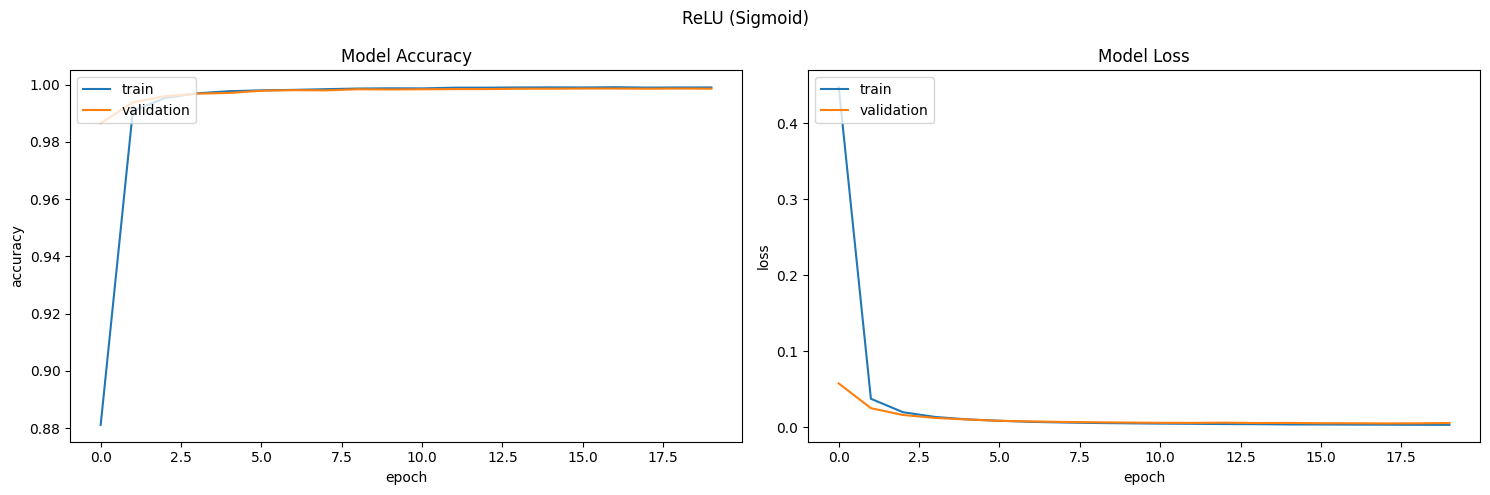

701/701 [==============================] - 0s 450us/step
Leaky ReLU (Sigmoid):
	Time to train: 42.2818s
	Time to test: 35.3494s


<Figure size 640x480 with 0 Axes>

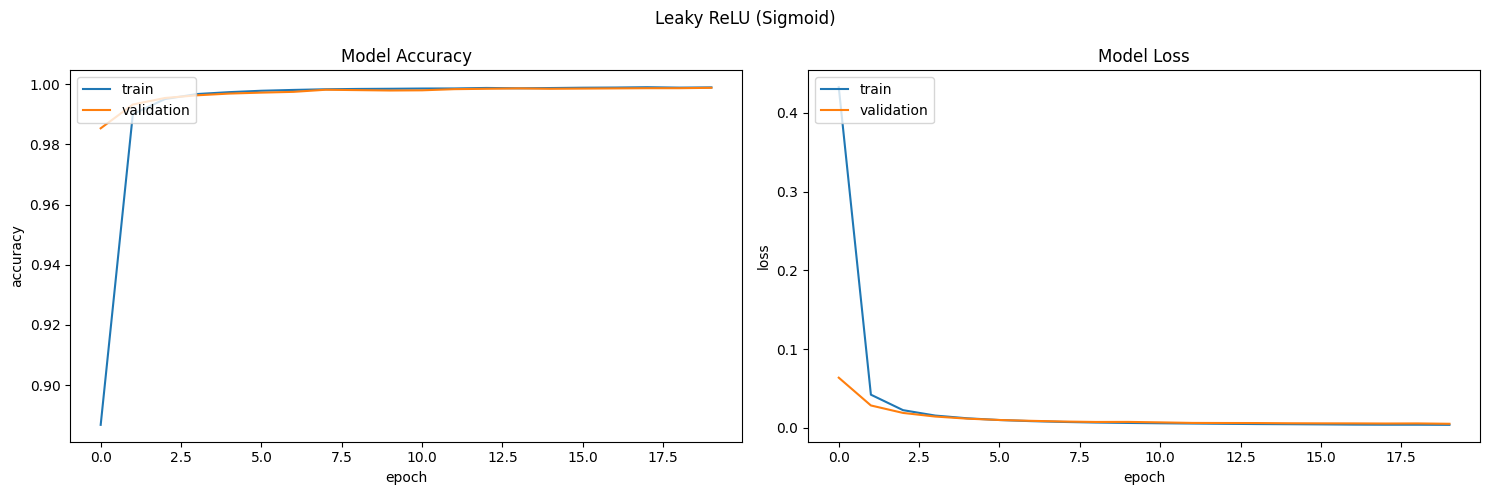

701/701 [==============================] - 0s 312us/step
Parametric ReLU (Sigmoid):
	Time to train: 42.0728s
	Time to test: 27.7099s


<Figure size 640x480 with 0 Axes>

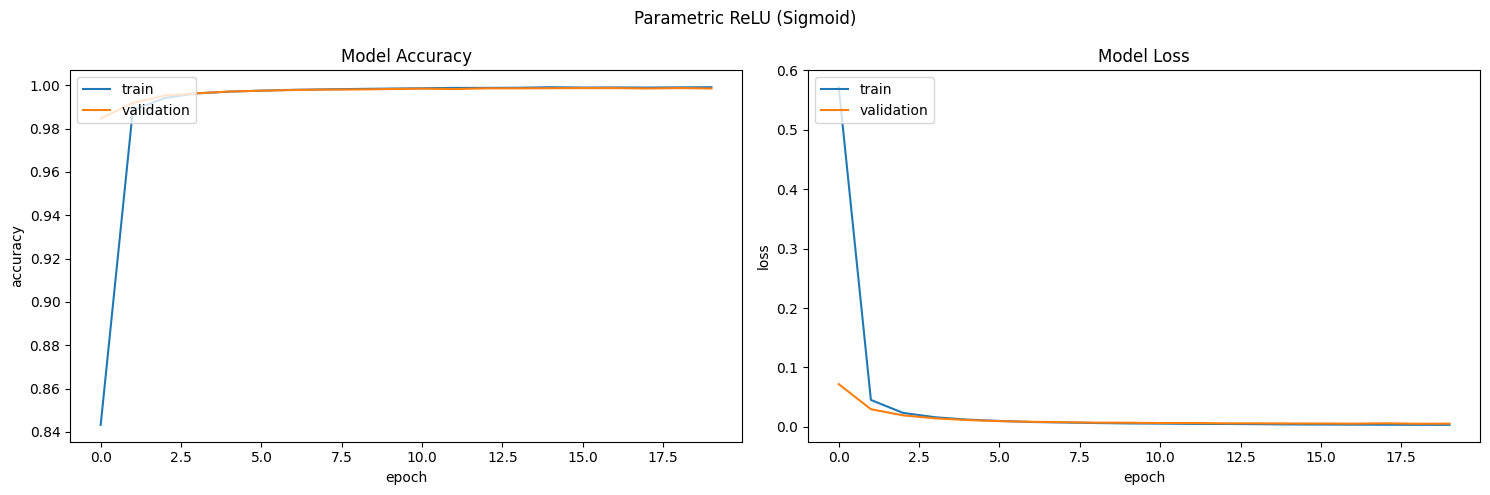

701/701 [==============================] - 0s 355us/step
ELU (Sigmoid):
	Time to train: 44.1406s
	Time to test: 29.0172s


<Figure size 640x480 with 0 Axes>

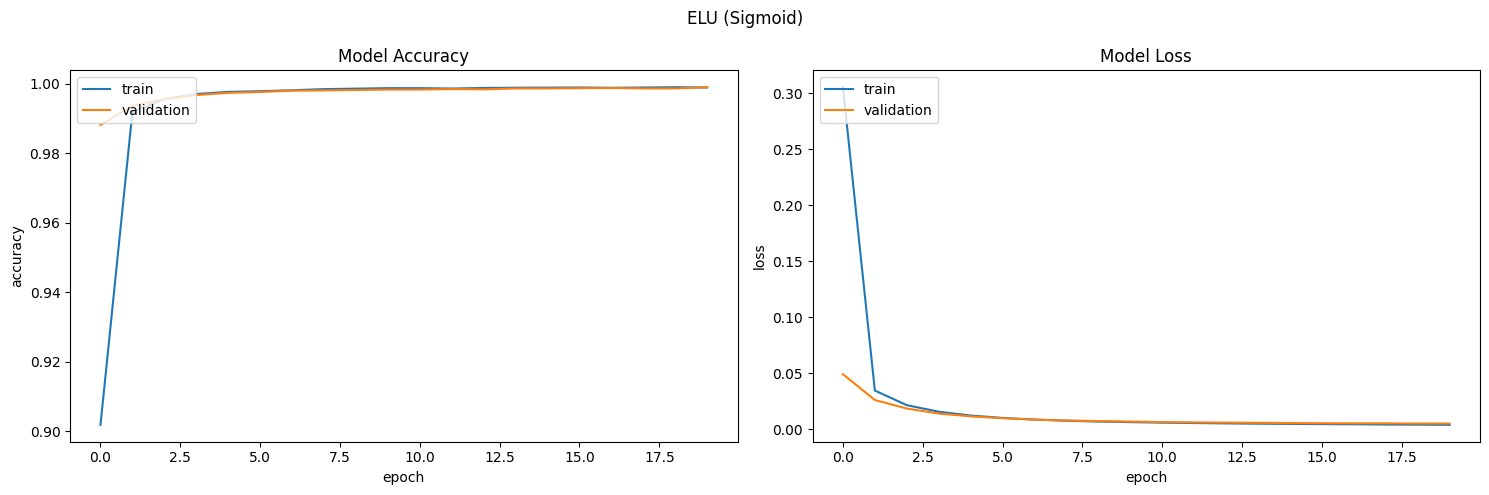

701/701 [==============================] - 0s 329us/step
GeLU (Sigmoid):
	Time to train: 44.6187s
	Time to test: 28.7424s


<Figure size 640x480 with 0 Axes>

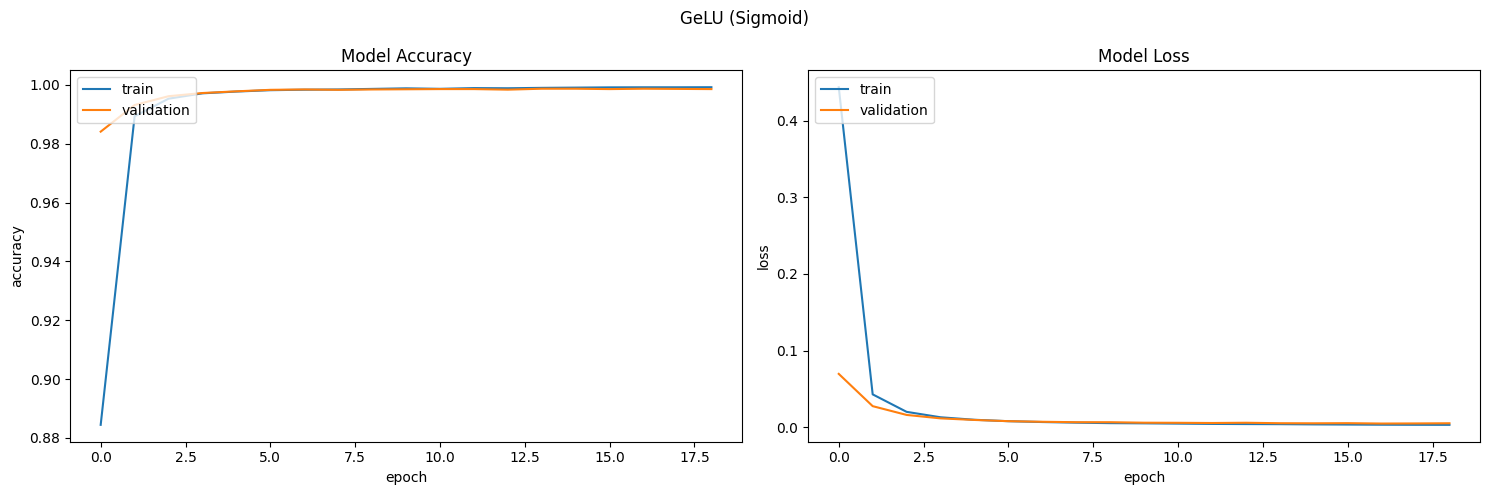

701/701 [==============================] - 0s 313us/step
Tanh (Sigmoid):
	Time to train: 40.1054s
	Time to test: 32.6206s


<Figure size 640x480 with 0 Axes>

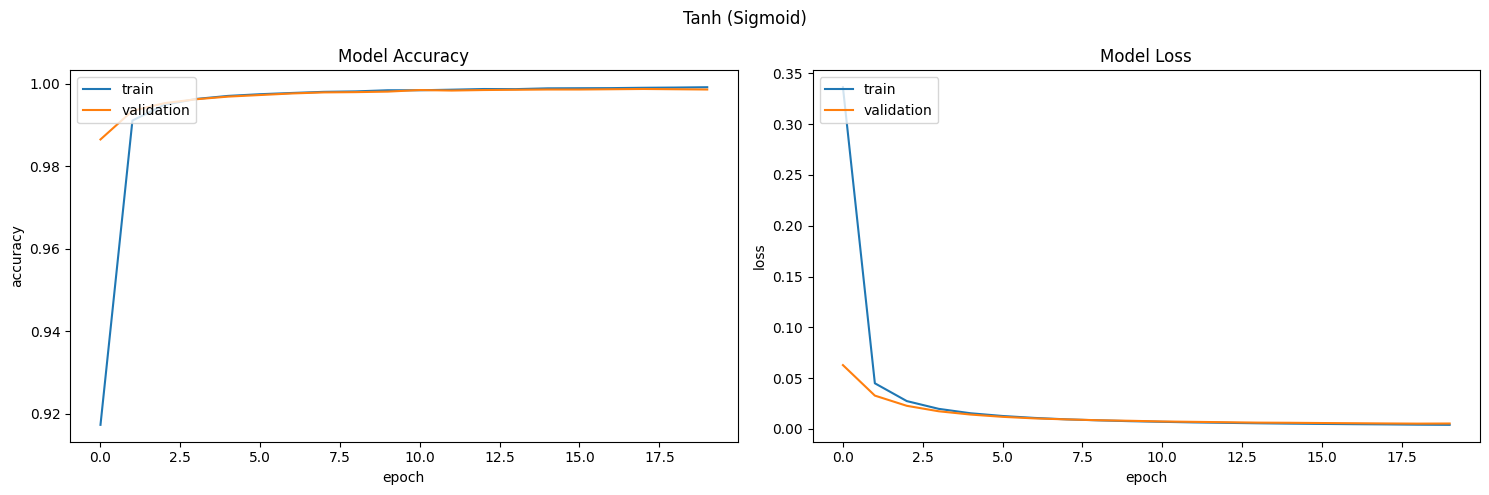

701/701 [==============================] - 0s 396us/step
Sigmoid (Sigmoid):
	Time to train: 40.1556s
	Time to test: 26.2412s


<Figure size 640x480 with 0 Axes>

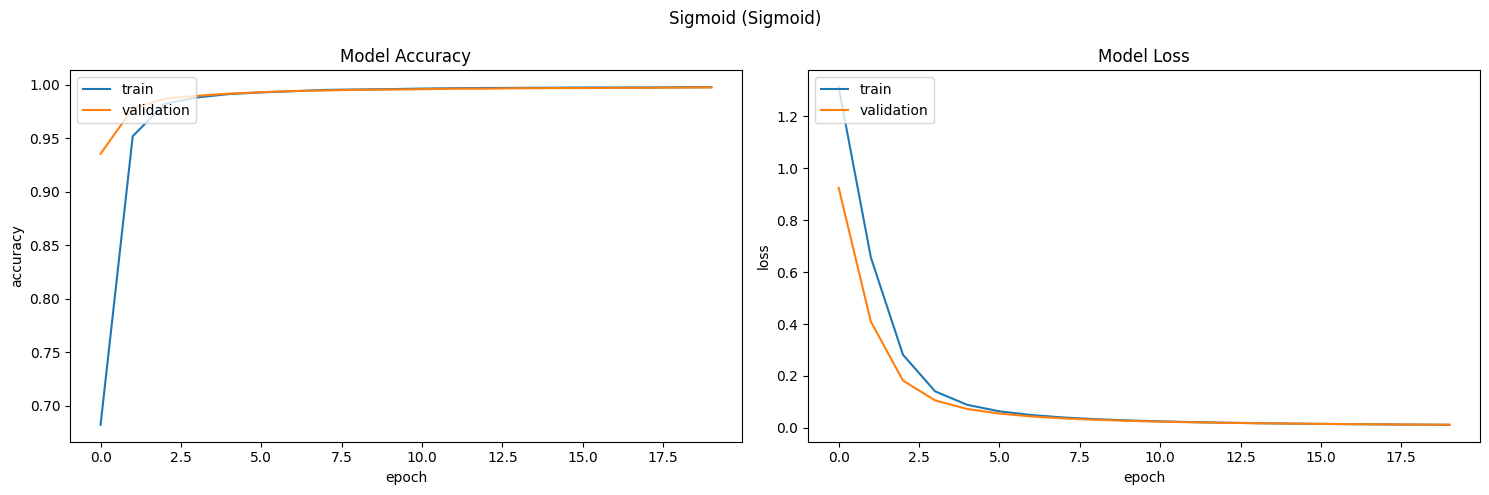

701/701 [==============================] - 0s 315us/step
Softmax (Sigmoid):
	Time to train: 40.4834s
	Time to test: 33.7981s


<Figure size 640x480 with 0 Axes>

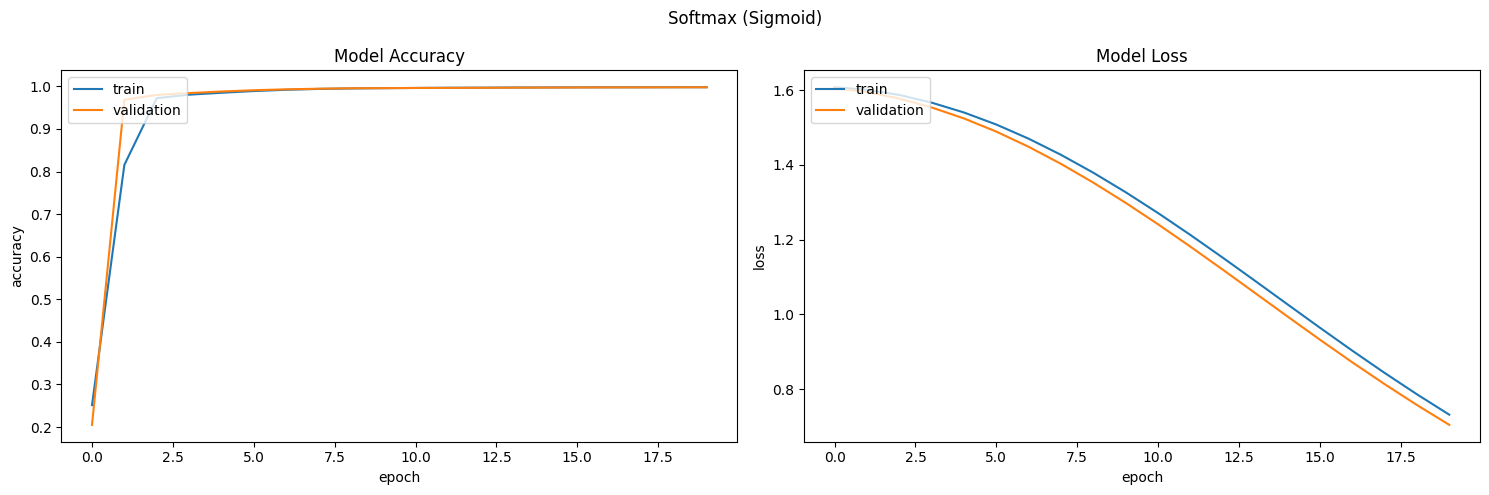

701/701 [==============================] - 0s 339us/step
Softplus (Sigmoid):
	Time to train: 40.3436s
	Time to test: 30.0265s


<Figure size 640x480 with 0 Axes>

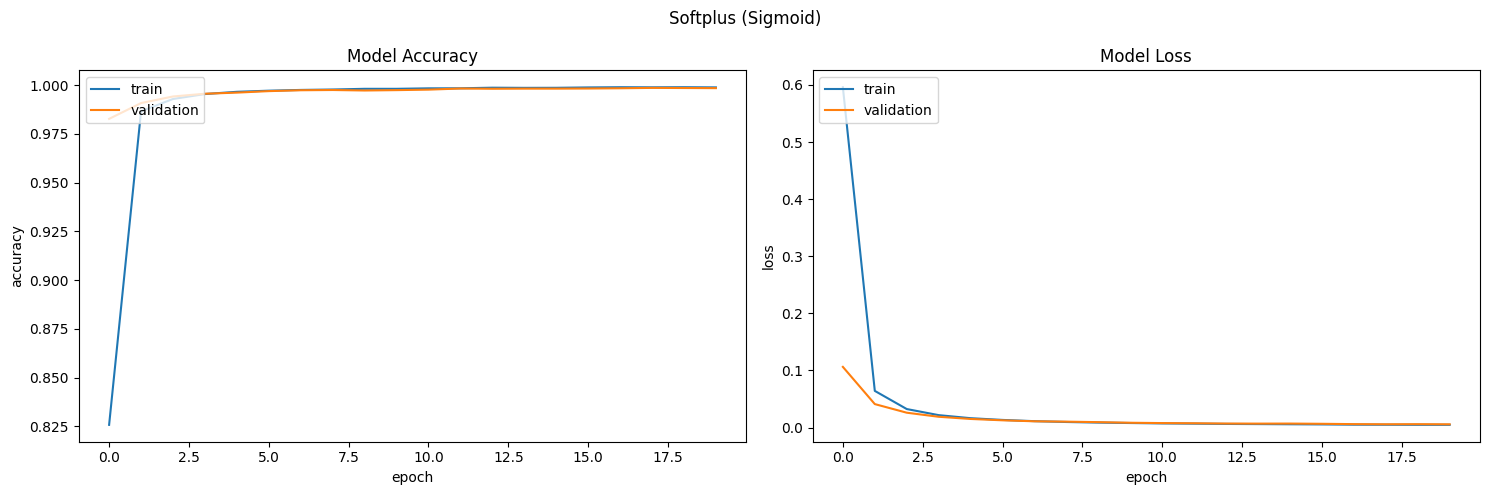

701/701 [==============================] - 0s 343us/step
Softsign (Sigmoid):
	Time to train: 41.3736s
	Time to test: 27.2682s


<Figure size 640x480 with 0 Axes>

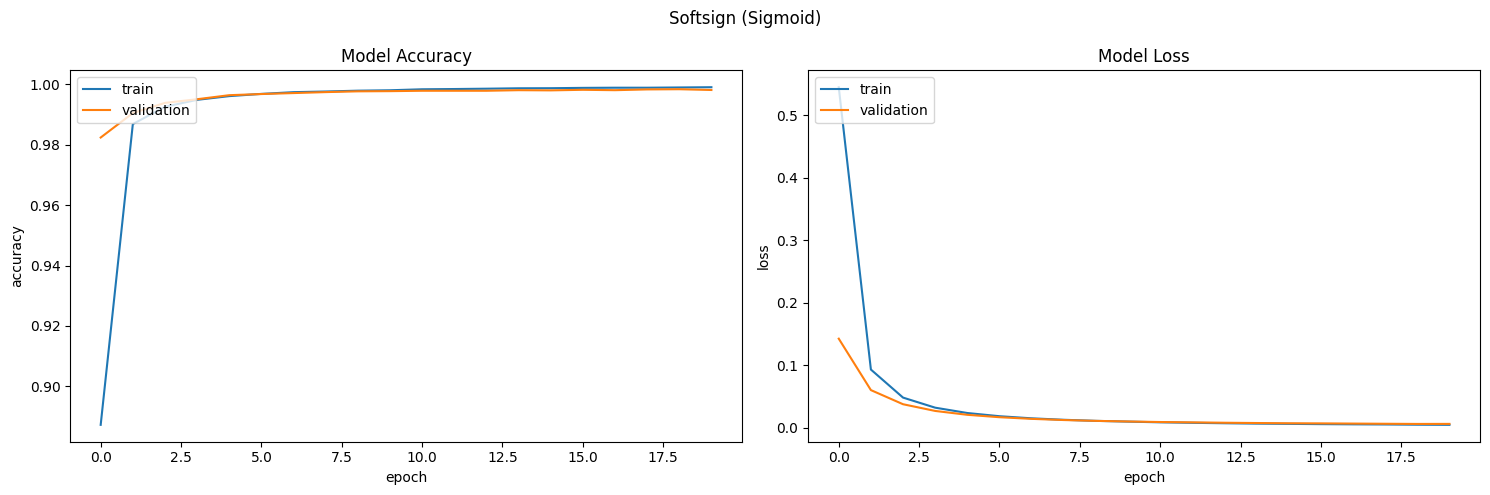

<Figure size 640x480 with 0 Axes>

In [69]:
#Test out all of thse activation functions, but with a sigmoid output function
for label, fun in activation_functions:
    network = build_activation_network(fun, 'sigmoid')
    history = perform_param_test(network, dfs_touse['Standard'], f"{label} (Sigmoid)", 1000, 20, callbacks=callbacks)
    plot_results(history, f"{label} (Sigmoid)")

Next, we will test the SELU activation, but with the standardized dataset (which is needed for this function), and the needed kernel initialization.

701/701 [==============================] - 0s 399us/step
SELU:
	Time to train: 43.1446s
	Time to test: 32.9432s


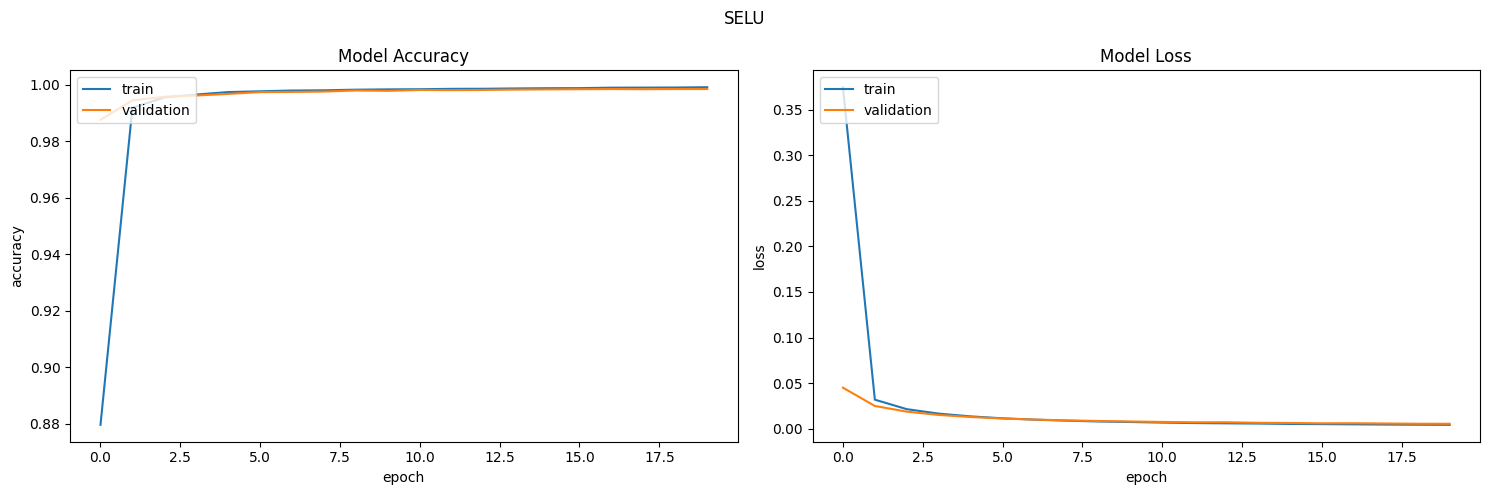

701/701 [==============================] - 0s 313us/step
SELU (Sigmoid):
	Time to train: 42.7927s
	Time to test: 30.7540s


<Figure size 640x480 with 0 Axes>

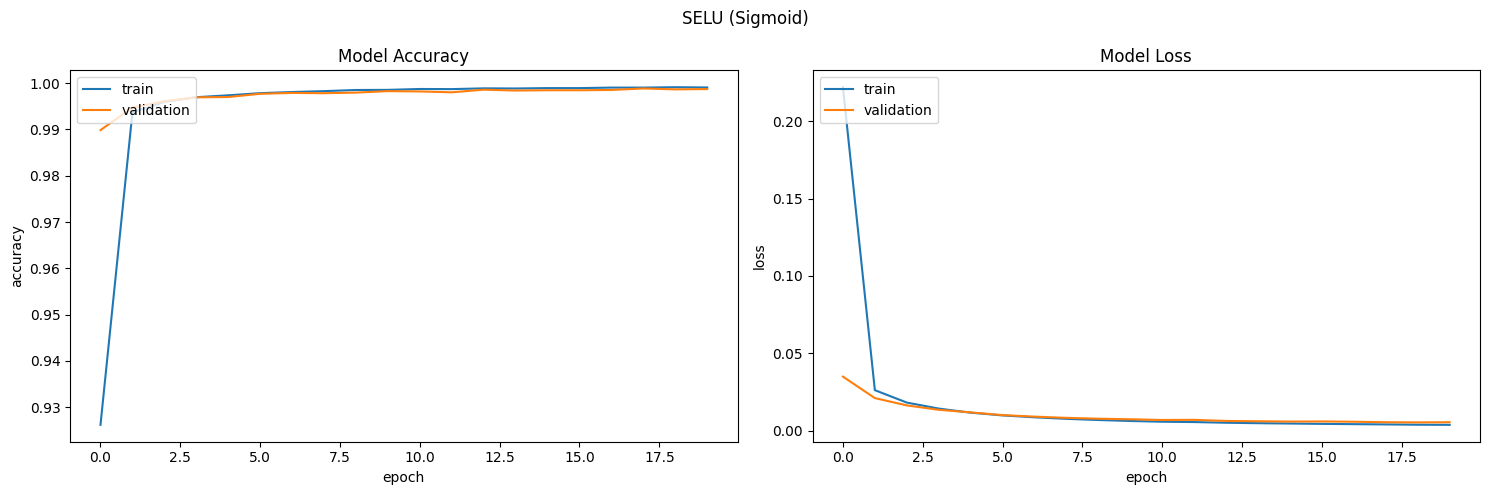

<Figure size 640x480 with 0 Axes>

In [70]:
#Test out the SELU activation function

def build_selu_network(output_activation):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation='selu', kernel_initializer='lecun_normal'))
    network.add(Dense(80, activation='selu', kernel_initializer='lecun_normal'))
    network.add(Dense(5, activation=output_activation))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    
    return network

#Test with softmax
network = build_selu_network('softmax')
history = perform_param_test(network, dfs_touse['Standard'], "SELU", 1000, 20, callbacks=callbacks)
plot_results(history, "SELU")

#Test with sigmoid
network = build_selu_network('sigmoid')
history = perform_param_test(network, dfs_touse['Standard'], "SELU (Sigmoid)", 1000, 20, callbacks=callbacks)
plot_results(history, "SELU (Sigmoid)")

### Check out the results of all the activation functions

In [83]:
#Test out all of these activation functions (softmax)
for label, fun in activation_functions:
    history = perform_param_cv_test(build_activation_network, dfs_touse['Standard'], label, 1000, 20, fun, callbacks=callbacks)

ReLU - fold number 0:
	Time to train: 34.4767s
234/234 [==============================] - 0s 411us/step
	Time to test: 8.1754s
ReLU - fold number 1:
	Time to train: 56.1399s
234/234 [==============================] - 0s 417us/step
	Time to test: 10.9964s
ReLU - fold number 2:
	Time to train: 59.9265s
234/234 [==============================] - 0s 603us/step
	Time to test: 11.5278s
ReLU - fold number 3:
	Time to train: 60.7250s
234/234 [==============================] - 0s 723us/step
	Time to test: 10.9484s
ReLU - fold number 4:
	Time to train: 52.4996s
234/234 [==============================] - 0s 769us/step
	Time to test: 11.7816s
ReLU - fold number 5:
	Time to train: 53.3509s
234/234 [==============================] - 0s 374us/step
	Time to test: 10.9036s
ReLU - fold number 6:
	Time to train: 52.8754s
234/234 [==============================] - 0s 395us/step
	Time to test: 11.3174s
ReLU - fold number 7:
	Time to train: 50.6743s
234/234 [==============================] - 0s 625us/step
	

In [84]:
#Test out all of thse activation functions, but with a sigmoid output function
for label, fun in activation_functions:
    history = perform_param_cv_test(build_sigmoid_activation_network, dfs_touse['Standard'], f"{label} (Sigmoid)", 1000, 20, fun, callbacks=callbacks)

ReLU (Sigmoid) - fold number 0:
	Time to train: 32.0764s
234/234 [==============================] - 0s 371us/step
	Time to test: 6.5090s
ReLU (Sigmoid) - fold number 1:
	Time to train: 32.8169s
234/234 [==============================] - 0s 383us/step
	Time to test: 6.5063s
ReLU (Sigmoid) - fold number 2:
	Time to train: 33.7024s
234/234 [==============================] - 0s 372us/step
	Time to test: 6.5050s
ReLU (Sigmoid) - fold number 3:
	Time to train: 32.0555s
234/234 [==============================] - 0s 378us/step
	Time to test: 6.5753s
ReLU (Sigmoid) - fold number 4:
	Time to train: 32.6062s
234/234 [==============================] - 0s 377us/step
	Time to test: 6.2865s
ReLU (Sigmoid) - fold number 5:
	Time to train: 29.9995s
234/234 [==============================] - 0s 349us/step
	Time to test: 6.0222s
ReLU (Sigmoid) - fold number 6:
	Time to train: 31.0523s
234/234 [==============================] - 0s 371us/step
	Time to test: 6.1800s
ReLU (Sigmoid) - fold number 7:
	Time to 

In [87]:
#Test out the SELU activation function

#Test with softmax
perform_param_cv_test(build_selu_network, dfs_touse['Standard'], "SELU", 1000, 20, 'softmax', callbacks=callbacks)

#Test with sigmoid
perform_param_cv_test(build_selu_network, dfs_touse['Standard'], "SELU (Sigmoid)", 1000, 20, 'sigmoid', callbacks=callbacks)

SELU - fold number 0:
	Time to train: 35.2347s
234/234 [==============================] - 0s 385us/step
	Time to test: 6.3392s
SELU - fold number 1:
	Time to train: 31.9095s
234/234 [==============================] - 0s 392us/step
	Time to test: 6.5231s
SELU - fold number 2:
	Time to train: 33.8118s
234/234 [==============================] - 0s 441us/step
	Time to test: 6.8383s
SELU - fold number 3:
	Time to train: 35.0681s
234/234 [==============================] - 0s 406us/step
	Time to test: 6.8823s
SELU - fold number 4:
	Time to train: 34.6422s
234/234 [==============================] - 0s 423us/step
	Time to test: 6.8078s
SELU - fold number 5:
	Time to train: 34.8047s
234/234 [==============================] - 0s 418us/step
	Time to test: 6.7364s
SELU - fold number 6:
	Time to train: 33.5416s
234/234 [==============================] - 0s 401us/step
	Time to test: 6.5318s
SELU - fold number 7:
	Time to train: 33.0907s
234/234 [==============================] - 0s 376us/step
	Time t

{'Accuracy': 0.998942369222641,
 'Precision_Basmati': 0.9992002216004536,
 'Precision_Arborio': 0.9985349688795271,
 'Precision_Jasmine': 0.9976705581295185,
 'Precision_Ipsala': 1.0,
 'Precision_Karacadag': 0.9993338654242331,
 'Precision_avg': 0.9989436938605684,
 'Precision_std': 0.0011197901829902595,
 'Recall_Basmati': 0.999,
 'Recall_Arborio': 0.9980666666666667,
 'Recall_Jasmine': 0.9983997331554371,
 'Recall_Ipsala': 0.9999319727891157,
 'Recall_Karacadag': 0.9993333333333332,
 'Recall_avg': 0.9989423790578927,
 'Recall_std': 0.0010396906001036237,
 'F1_Basmati': 0.9990999442777863,
 'F1_Arborio': 0.998299318807376,
 'F1_Jasmine': 0.9980338521931975,
 'F1_Ipsala': 0.9999659748213677,
 'F1_Karacadag': 0.9993333998001258,
 'F1_avg': 0.9989423999242533,
 'F1_std': 0.0008308224172556278}

In [88]:
#Build results df
activation_df = pd.DataFrame.from_dict(param_results, orient='index')

#Get rid of all the columns except F1 scores
f1_activation_df = activation_df[['F1_avg', "Accuracy", 'F1_Basmati','F1_Arborio','F1_Jasmine','F1_Ipsala','F1_Karacadag']]

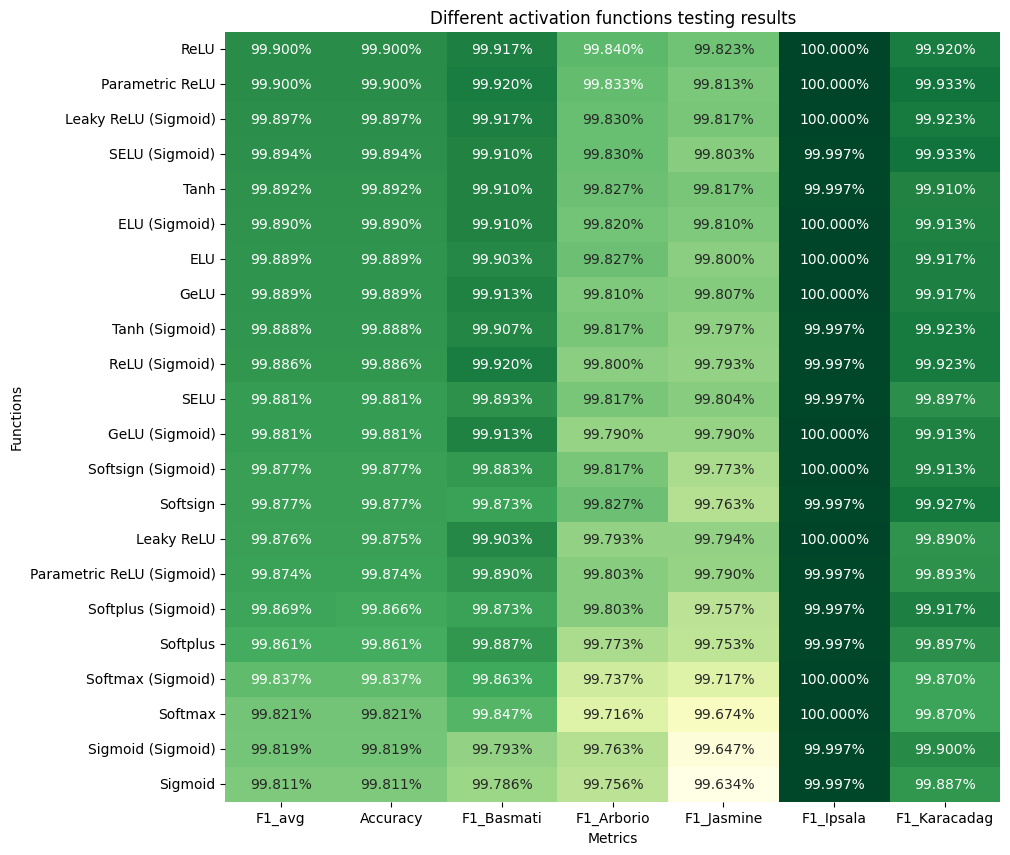

<Figure size 640x480 with 0 Axes>

In [89]:
#Heatmap
sorted_f1_activation_df = f1_activation_df.sort_values('F1_avg', axis=0, ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(sorted_f1_activation_df, annot=sorted_f1_activation_df, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Different activation functions testing results")
plt.xlabel("Metrics")
plt.ylabel("Functions")
plt.savefig(f"{figure_folder}activation-functions-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

It seems that using the **parameteric ReLU** activation function for our hidden layers, and using the **softmax** activation function for our ouput layer, provided the best results.

## Perform K-Fold Cross Validation for final testing results

In [92]:
final_results = {}

In [90]:
def perform_final_cv_test(build_network, data, label, batch_size, epochs, network_param, callbacks = None):
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    res = cv_test_network(build_network, data, reverse_target_column_dict, label, batch_size, 
                            epochs, callbacks = callbacks, network_build_param=network_param)
    
    global final_results
    final_results[label] = res    
    
    return res

def build_final_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation=PReLU()))
    network.add(Dense(80, activation=PReLU()))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

def build_final_weighted_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation=PReLU(), kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(80, activation=PReLU(), kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

In [93]:
perform_final_cv_test(build_final_network, dfs_touse['Standard'], "Standardized data + NO weight reg", 1000, 20, None, callbacks=callbacks)
perform_final_cv_test(build_final_network, dfs_touse['Power'], "Power transformed data + NO weight reg", 1000, 20, None, callbacks=callbacks)
perform_final_cv_test(build_final_weighted_network, dfs_touse['Standard'], "Standardized data + weight reg", 1000, 20, None, callbacks=callbacks)
perform_final_cv_test(build_final_weighted_network, dfs_touse['Power'], "Power transformed data + weight reg", 1000, 20, None, callbacks=callbacks)

Standardized data + NO weight reg - fold number 0:
	Time to train: 35.8075s
234/234 [==============================] - 0s 438us/step
	Time to test: 6.6700s
Standardized data + NO weight reg - fold number 1:
	Time to train: 34.3608s
234/234 [==============================] - 0s 432us/step
	Time to test: 6.6872s
Standardized data + NO weight reg - fold number 2:
	Time to train: 33.8847s
234/234 [==============================] - 0s 423us/step
	Time to test: 6.7139s
Standardized data + NO weight reg - fold number 3:
	Time to train: 36.9076s
234/234 [==============================] - 0s 441us/step
	Time to test: 6.8837s
Standardized data + NO weight reg - fold number 4:
	Time to train: 35.1396s
234/234 [==============================] - 0s 488us/step
	Time to test: 6.8142s
Standardized data + NO weight reg - fold number 5:
	Time to train: 35.4489s
234/234 [==============================] - 0s 432us/step
	Time to test: 6.7389s
Standardized data + NO weight reg - fold number 6:
	Time to trai

{'Accuracy': 0.9980186283588409,
 'Precision_Basmati': 0.9992657310447758,
 'Precision_Arborio': 0.9972640753275762,
 'Precision_Jasmine': 0.9942956336169587,
 'Precision_Ipsala': 1.0,
 'Precision_Karacadag': 0.9993330659551984,
 'Precision_avg': 0.9980238806274248,
 'Precision_std': 0.0022161665374281357,
 'Recall_Basmati': 0.9974666666666667,
 'Recall_Arborio': 0.9960666666666669,
 'Recall_Jasmine': 0.9983998665777186,
 'Recall_Ipsala': 1.0,
 'Recall_Karacadag': 0.9982,
 'Recall_avg': 0.9980186215473758,
 'Recall_std': 0.0015590927159298631,
 'F1_Basmati': 0.9983649195026418,
 'F1_Arborio': 0.9966638380758498,
 'F1_Jasmine': 0.9963416856955837,
 'F1_Ipsala': 1.0,
 'F1_Karacadag': 0.9987659214918869,
 'F1_avg': 0.9980193460202506,
 'F1_std': 0.001460726356722433}

In [94]:
#Build results df
final_df = pd.DataFrame.from_dict(final_results, orient='index')

#Get rid of all the columns except F1 scores
f1_final = final_df[['F1_avg', "Accuracy", 'F1_Basmati','F1_Arborio','F1_Jasmine','F1_Ipsala','F1_Karacadag']]

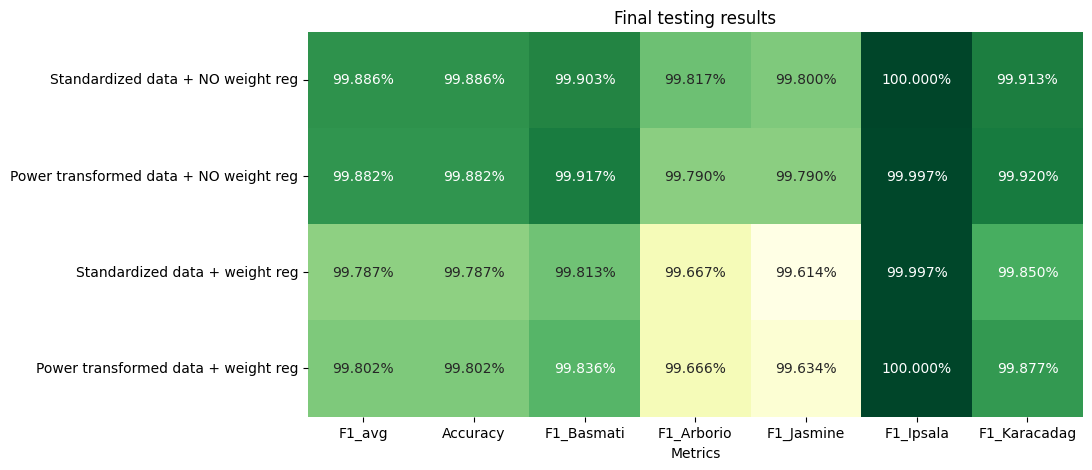

<Figure size 640x480 with 0 Axes>

In [98]:
plt.figure(figsize=(10,5))
sns.heatmap(f1_final, annot=f1_final, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Final testing results")
plt.xlabel("Metrics")
plt.savefig(f"{figure_folder}final-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()